https://www.kaggle.com/competitions/ieee-fraud-detection

Este notebook engloba os seguinte passos:

* Feature Engineering
    * Tratando Colunas com Valores Faltantes (deletar colunas com 75% de valores faltantes)
    * Tratando Colunas com valores únicos (deletar)
    * Tratando Linhas com Valores Faltantes (deletar linhas com 75% de valores faltantes)
    * Substituindo NaNs remanescentes por média e moda
    * Codificação de variáveis categóricas
* Redução de dimensionalidade
    * Seleção de atributos com teste do Qui-Quadrado (top 25 e top 75)
    * Seleção de atributos com teste ANOVA (top 25 e top 75)
* Separação entre base de treino e de teste, a partir da base de treino
* Balanceamento de classes
    * Undersample
        * Near Miss
    * Oversample
        * Resample
        * ROS
        * SMOTE
        * Borderline SMOTE
        * AdaSyn
* Treinamento dos algoritmos e análise de desempenho, com validação cruzada (10 folds)
    * Algoritmos utilizados
        * Extra Trees
        * Random Forest
        * Decision Tree
        * CatBoost
        * Gradient Boost Classifier
        * AdaBoost
        * Logistic Regression
        * KNN
        * Naive Bayes
    * Métricas de desempenho
        * F1-score positivo
        * F1-score negativo
        * Wall time

# Sobre os Dados

## Tabela Transação

* `TransactionDT`: timedelta from a given reference datetime (not an actual timestamp)

* `TransactionAMT`: transaction payment amount in USD

* `ProductCD`: product code, the product for each transaction

* `card1 - card6`: payment card information, such as card type, card category, issue bank, country, etc.

* `addr`: address

* `dist`: distance

* `P_ and (R__) emaildomain`: purchaser and recipient email domain

* `C1-C14`: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.

* `D1-D15`: timedelta, such as days between previous transaction, etc.

* `M1-M9`: match, such as names on card and address, etc.

* `Vxxx`: Vesta engineered rich features, including ranking, counting, and other entity relations.

### Categorical Features

* `ProductCD`

* `card1 - card6`

* `addr1, addr2`

* `P_emaildomain`

* `R_emaildomain`

* `M1 - M9`

## Tabela Identidade

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.

They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

### Categorical Features

* `DeviceType`

* `DeviceInfo`

* `id_12 - id_38`

# Importando Bibliotecas

In [1]:
# inicializando cronômetro
import time
t0 = time.time()

In [2]:
!pip install lightgbm
!pip install xgboost
!pip install catboost

!pip install scikit-learn==1.2.2
!pip install numpy==1.24.0
!pip install pandas==2.0.2
!pip install imbalanced-learn==0.10.1
#!pip install scikit-learn==1.1.1
#!pip install numpy==1.22.4
#!pip install pandas==1.2.4
#!pip install imbalanced-learn==0.10.1

In [3]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, log_loss, roc_auc_score, accuracy_score
from scipy import stats
pd.options.display.max_rows = 999
pd.options.display.precision = 15

import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, \
KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.style.use("ggplot")
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

In [4]:
# checar utilização de memória
!pip install GPUtil

from GPUtil import showUtilization as gpu_usage
gpu_usage() 

| ID | GPU | MEM |
------------------


In [5]:
#limpando cache do CUDA para melhor desempenho do paralelismo
!pip install torch
import torch
torch.cuda.empty_cache()

# Importando Dados

In [6]:
folder_path = ''
train_identity = pd.read_csv(f'{folder_path}train_identity.csv')
train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv')
test_identity = pd.read_csv(f'{folder_path}test_identity.csv')
test_transaction = pd.read_csv(f'{folder_path}test_transaction.csv')
sub = pd.read_csv(f'{folder_path}sample_submission.csv')

# combinando dados de transações e de identidade associada às transações (p.ex., IP e browser utilizado)
train = pd.merge(train_transaction, train_identity, on = 'TransactionID', how = 'left')
test = pd.merge(test_transaction, test_identity, on = 'TransactionID', how = 'left')

In [7]:
print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

Train dataset has 590540 rows and 434 columns.
Test dataset has 506691 rows and 433 columns.


# Análise Exploratória de Dados

## Estatística Básica

In [8]:
# função resumetable traz as estatísticas básicas do conjunto de dados
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = \
        round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [9]:
resumetable(train)[:25]

Dataset Shape: (590540, 434)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int64,0,590540,2987000,2987001,2987002,19.170000000000002
1,isFraud,int64,0,2,0,0,0,0.220000000000000
2,TransactionDT,int64,0,573349,86400,86401,86469,19.109999999999999
3,TransactionAmt,float64,0,20902,68.5,29.0,59.0,8.350000000000000
4,ProductCD,object,0,5,W,W,W,1.280000000000000
5,card1,int64,0,13553,13926,2755,4663,9.970000000000001
6,card2,float64,8933,500,NaN,404.0,490.0,6.320000000000000
7,card3,float64,1565,114,150.0,150.0,150.0,0.680000000000000
8,card4,object,1577,4,discover,mastercard,visa,1.090000000000000
9,card5,float64,4259,119,142.0,102.0,166.0,2.660000000000000


In [10]:
resumetable(test)[:25]

Dataset Shape: (506691, 433)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int64,0,506691,3663549,3663550,3663551,18.949999999999999
1,TransactionDT,int64,0,494686,18403224,18403263,18403310,18.899999999999999
2,TransactionAmt,float64,0,14119,31.949999999999999,49.0,171.0,8.080000000000000
3,ProductCD,object,0,5,W,W,W,1.370000000000000
4,card1,int64,0,13244,10409,4272,4476,9.949999999999999
5,card2,float64,8654,497,111.0,111.0,574.0,6.280000000000000
6,card3,float64,3002,115,150.0,150.0,150.0,0.810000000000000
7,card4,object,3086,4,visa,visa,visa,1.050000000000000
8,card5,float64,4547,102,226.0,226.0,226.0,2.630000000000000
9,card6,object,3007,3,debit,debit,debit,0.790000000000000


In [11]:
# checando todas as colunas dos conjuntos de dado de treino e teste
for i in list(train):
    print("'" + i + "'" + ", ")

'TransactionID', 
'isFraud', 
'TransactionDT', 
'TransactionAmt', 
'ProductCD', 
'card1', 
'card2', 
'card3', 
'card4', 
'card5', 
'card6', 
'addr1', 
'addr2', 
'dist1', 
'dist2', 
'P_emaildomain', 
'R_emaildomain', 
'C1', 
'C2', 
'C3', 
'C4', 
'C5', 
'C6', 
'C7', 
'C8', 
'C9', 
'C10', 
'C11', 
'C12', 
'C13', 
'C14', 
'D1', 
'D2', 
'D3', 
'D4', 
'D5', 
'D6', 
'D7', 
'D8', 
'D9', 
'D10', 
'D11', 
'D12', 
'D13', 
'D14', 
'D15', 
'M1', 
'M2', 
'M3', 
'M4', 
'M5', 
'M6', 
'M7', 
'M8', 
'M9', 
'V1', 
'V2', 
'V3', 
'V4', 
'V5', 
'V6', 
'V7', 
'V8', 
'V9', 
'V10', 
'V11', 
'V12', 
'V13', 
'V14', 
'V15', 
'V16', 
'V17', 
'V18', 
'V19', 
'V20', 
'V21', 
'V22', 
'V23', 
'V24', 
'V25', 
'V26', 
'V27', 
'V28', 
'V29', 
'V30', 
'V31', 
'V32', 
'V33', 
'V34', 
'V35', 
'V36', 
'V37', 
'V38', 
'V39', 
'V40', 
'V41', 
'V42', 
'V43', 
'V44', 
'V45', 
'V46', 
'V47', 
'V48', 
'V49', 
'V50', 
'V51', 
'V52', 
'V53', 
'V54', 
'V55', 
'V56', 
'V57', 
'V58', 
'V59', 
'V60', 
'V61', 
'V62', 
'V63', 
'V64', 
'V6

In [12]:
for i in list(test):
    print("'" + i + "'" + ", ")

'TransactionID', 
'TransactionDT', 
'TransactionAmt', 
'ProductCD', 
'card1', 
'card2', 
'card3', 
'card4', 
'card5', 
'card6', 
'addr1', 
'addr2', 
'dist1', 
'dist2', 
'P_emaildomain', 
'R_emaildomain', 
'C1', 
'C2', 
'C3', 
'C4', 
'C5', 
'C6', 
'C7', 
'C8', 
'C9', 
'C10', 
'C11', 
'C12', 
'C13', 
'C14', 
'D1', 
'D2', 
'D3', 
'D4', 
'D5', 
'D6', 
'D7', 
'D8', 
'D9', 
'D10', 
'D11', 
'D12', 
'D13', 
'D14', 
'D15', 
'M1', 
'M2', 
'M3', 
'M4', 
'M5', 
'M6', 
'M7', 
'M8', 
'M9', 
'V1', 
'V2', 
'V3', 
'V4', 
'V5', 
'V6', 
'V7', 
'V8', 
'V9', 
'V10', 
'V11', 
'V12', 
'V13', 
'V14', 
'V15', 
'V16', 
'V17', 
'V18', 
'V19', 
'V20', 
'V21', 
'V22', 
'V23', 
'V24', 
'V25', 
'V26', 
'V27', 
'V28', 
'V29', 
'V30', 
'V31', 
'V32', 
'V33', 
'V34', 
'V35', 
'V36', 
'V37', 
'V38', 
'V39', 
'V40', 
'V41', 
'V42', 
'V43', 
'V44', 
'V45', 
'V46', 
'V47', 
'V48', 
'V49', 
'V50', 
'V51', 
'V52', 
'V53', 
'V54', 
'V55', 
'V56', 
'V57', 
'V58', 
'V59', 
'V60', 
'V61', 
'V62', 
'V63', 
'V64', 
'V65', 
'V66', 

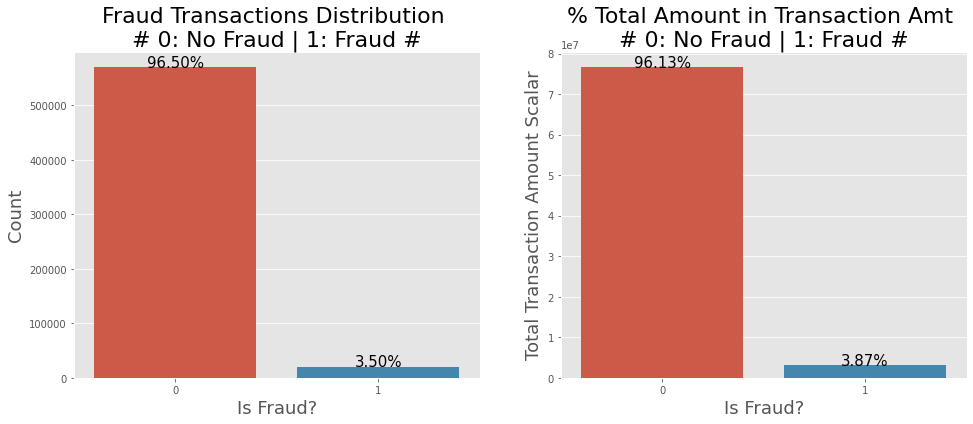

In [13]:
# checando o desbalanceamento dos dados por quantidade de transações e valor das transações
# ("TransactionAmt")
train['TransactionAmt'] = train['TransactionAmt'].astype(float)
total = len(train)
total_amt = train.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize = (16, 6))

plt.subplot(121)
g = sns.countplot(x = 'isFraud', data = train, )
g.set_title("Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #", fontsize = 22)
g.set_xlabel("Is Fraud?", fontsize = 18)
g.set_ylabel('Count', fontsize = 18)

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x() + p.get_width()/2.,
          height + 3,
          '{:1.2f}%'.format(height/total * 100),
          ha = "center", fontsize = 15)

perc_amt = (train.groupby(['isFraud'])['TransactionAmt'].sum())
perc_amt = perc_amt.reset_index()
plt.subplot(122)
g1 = sns.barplot(x = 'isFraud', y = 'TransactionAmt', dodge = True, data = perc_amt)
g1.set_title("% Total Amount in Transaction Amt \n# 0: No Fraud | 1: Fraud #", fontsize = 22)
g1.set_xlabel("Is Fraud?", fontsize = 18)
g1.set_ylabel('Total Transaction Amount Scalar', fontsize = 18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x() + p.get_width()/2.,
           height + 3,
           '{:1.2f}%'.format(height/total_amt * 100),
           ha = "center", fontsize = 15)

# Feature Engineering

## Convertendo "TransactionDT" em data, dias, horários e dias da semana

In [14]:
# a primeira data é 01/12/2017 e será usada o timedelta para calcular os atributos de 
# datas e horários

import datetime

START_DATE = '2017-12-01'
start_date = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
train["Date"] = train['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta
                                                             (seconds = x)))

train['_Weekdays'] = train['Date'].dt.dayofweek
train['_Hours'] = train['Date'].dt.hour
train['_Days'] = train['Date'].dt.day

In [15]:
# fazendo o mesmo para base teste

START_DATE = '2017-12-01'
start_date = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
test["Date"] = test['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta
                                                             (seconds = x)))

test['_Weekdays'] = test['Date'].dt.dayofweek
test['_Hours'] = test['Date'].dt.hour
test['_Days'] = test['Date'].dt.day

In [16]:
# método do Pandas para mostrar todas as linhas ao pedir para exibir um dataframe
pd.reset_option('display.max_rows')

## Equalizando nomes de colunas entre bases de treino e teste

In [17]:
# importante para seguir com ajustes na base de forma otimizada
train.columns.difference(test.columns)

Index(['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08',
       'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16',
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24',
       'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'isFraud'],
      dtype='object')

In [18]:
# ajustar colunas de teste
test.columns = test.columns.str.replace('-', '_')

In [19]:
# checando resultado final das diferenças
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Tratando Colunas com Valores Faltantes

In [20]:
# função para checar valores NaN
def NaN_percent(df, column_name):
    #me dá a posição 0 do resultado de df.shape
    row_count = df[column_name].shape[0]
    #df.count() conta os valores não vazios
    empty_values = row_count - df[column_name].count()
    return (100.0 * empty_values)/row_count

In [21]:
# lista completa de colunas com percentuais de NaNs
for i in list(train):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(train,i))+'%')

TransactionID: 0.0%
isFraud: 0.0%
TransactionDT: 0.0%
TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 1.5126833068039423%
card3: 0.26501168422122123%
card4: 0.267043722694483%
card5: 0.7212043214684865%
card6: 0.26602770345785215%
addr1: 11.12642666034477%
addr2: 11.12642666034477%
dist1: 59.6523520845328%
dist2: 93.62837403054831%
P_emaildomain: 15.99485216920107%
R_emaildomain: 76.75161716395164%
C1: 0.0%
C2: 0.0%
C3: 0.0%
C4: 0.0%
C5: 0.0%
C6: 0.0%
C7: 0.0%
C8: 0.0%
C9: 0.0%
C10: 0.0%
C11: 0.0%
C12: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.21488806854743117%
D2: 47.54919226470688%
D3: 44.514850814508755%
D4: 28.604666915026925%
D5: 52.46740271615809%
D6: 87.60676668811597%
D7: 93.40992989467267%
D8: 87.31229044603245%
D9: 87.31229044603245%
D10: 12.873302401192129%
D11: 47.29349409015477%
D12: 89.04104717715988%
D13: 89.50926270870728%
D14: 89.46946862193924%
D15: 15.090087038981272%
M1: 45.90713584177194%
M2: 45.90713584177194%
M3: 45.90713584177194%
M4: 47.658753005723575%
M5: 59.34

V309: 0.0020320384732617604%
V310: 0.0020320384732617604%
V311: 0.0020320384732617604%
V312: 0.0020320384732617604%
V313: 0.21488806854743117%
V314: 0.21488806854743117%
V315: 0.21488806854743117%
V316: 0.0020320384732617604%
V317: 0.0020320384732617604%
V318: 0.0020320384732617604%
V319: 0.0020320384732617604%
V320: 0.0020320384732617604%
V321: 0.0020320384732617604%
V322: 86.05496664070174%
V323: 86.05496664070174%
V324: 86.05496664070174%
V325: 86.05496664070174%
V326: 86.05496664070174%
V327: 86.05496664070174%
V328: 86.05496664070174%
V329: 86.05496664070174%
V330: 86.05496664070174%
V331: 86.05496664070174%
V332: 86.05496664070174%
V333: 86.05496664070174%
V334: 86.05496664070174%
V335: 86.05496664070174%
V336: 86.05496664070174%
V337: 86.05496664070174%
V338: 86.05496664070174%
V339: 86.05496664070174%
id_01: 75.5760829071697%
id_02: 76.14522301622245%
id_03: 88.76892335828225%
id_04: 88.76892335828225%
id_05: 76.82375452975243%
id_06: 76.82375452975243%
id_07: 99.12707013919463

In [22]:
# identificando colunas com mais de 75% dos valores como NaN
many_null_cols_train = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.75]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.75]

## Tratando Colunas com Valores Únicos

In [23]:
# checando se existem colunas apenas com um valor
one_value_cols_train = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

print(f'There are {len(one_value_cols_train)} columns in train dataset with one unique value.')
print(f'There are {len(one_value_cols_test)} columns in test dataset with one unique value.')

There are 0 columns in train dataset with one unique value.
There are 1 columns in test dataset with one unique value.


In [24]:
# identificando colunas com valor único
one_value_cols_train = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

In [25]:
# checando colunas com mais de 75% de valores únicos
big_top_value_cols_train = [col for col in train.columns if \
                            train[col].value_counts(dropna=False, normalize=True).values[0] > 0.75]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False,\
                                                                                 normalize=True).values[0] > 0.75]

## Concatenando as Colunas Desnecessárias e Removendo-as

In [26]:
cols_to_drop = list(set(many_null_cols_train + big_top_value_cols_train + \
                        one_value_cols_train + many_null_cols_test + big_top_value_cols_test + one_value_cols_test))

# excluir a coluna 'isFraud' da remoção
cols_to_drop.remove('isFraud')
len(cols_to_drop)

346

In [27]:
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

In [28]:
# checando novamente a diferença entre colunas das bases treino e teste
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Identificando Linhas com Valores Faltantes e Removendo-as

In [29]:
# checando e excluindo linhas com mais de 75% de valores faltantes
perc = 75.0 
min_count =  int(((100 - perc) / 100) * train.shape[1] + 1)
train = train.dropna(axis = 0, thresh = min_count)

min_count =  int(((100 - perc) / 100) * test.shape[1] + 1)
test = test.dropna(axis = 0, thresh = min_count)

In [30]:
train.shape

(590540, 92)

In [31]:
test.shape

(506691, 91)

## Remover colunas datetime e ID para balanceamento e redução de dimensionalidade

In [32]:
# remover TransactionID e datetime para balanceamento e redução de dimensionalidade
train = train.drop(['TransactionID', 'TransactionDT', 'Date'], axis = 1)
test = test.drop(['TransactionID', 'TransactionDT', 'Date'], axis = 1)

In [33]:
# checando por diferenças de colunas entre as bases de treino e teste
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Substituindo NaNs remanescentes por média (variáveis numéricas) e moda (variáveis categóricas) para pacotes de balanceamento e redução de dimensionalidade

In [34]:
# lista completa de colunas remanescentes com percentuais de NaNs
for i in list(train):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(train,i))+'%')

isFraud: 0.0%
TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 1.5126833068039423%
card4: 0.267043722694483%
card5: 0.7212043214684865%
addr1: 11.12642666034477%
dist1: 59.6523520845328%
P_emaildomain: 15.99485216920107%
C1: 0.0%
C2: 0.0%
C5: 0.0%
C6: 0.0%
C9: 0.0%
C11: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.21488806854743117%
D2: 47.54919226470688%
D3: 44.514850814508755%
D4: 28.604666915026925%
D5: 52.46740271615809%
D10: 12.873302401192129%
D11: 47.29349409015477%
D15: 15.090087038981272%
M1: 45.90713584177194%
M2: 45.90713584177194%
M3: 45.90713584177194%
M4: 47.658753005723575%
M5: 59.34940901547736%
M6: 28.678836319300977%
M7: 58.63531682866529%
M8: 58.633115453652586%
M9: 58.633115453652586%
V1: 47.29349409015477%
V2: 47.29349409015477%
V3: 47.29349409015477%
V4: 47.29349409015477%
V5: 47.29349409015477%
V6: 47.29349409015477%
V7: 47.29349409015477%
V8: 47.29349409015477%
V9: 47.29349409015477%
V10: 47.29349409015477%
V11: 47.29349409015477%
V12: 12.881938564703491%
V13: 12.88193

In [35]:
# das colunas com NaNs remanescentes, entender quais são de variáveis numéricas ou categóricas
pd.options.display.max_rows = 999
resumetable(train)

Dataset Shape: (590540, 89)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,isFraud,int64,0,2,0,0,0,0.220000000000000
1,TransactionAmt,float64,0,20902,68.5,29.0,59.0,8.350000000000000
2,ProductCD,object,0,5,W,W,W,1.280000000000000
3,card1,int64,0,13553,13926,2755,4663,9.970000000000001
4,card2,float64,8933,500,NaN,404.0,490.0,6.320000000000000
5,card4,object,1577,4,discover,mastercard,visa,1.090000000000000
6,card5,float64,4259,119,142.0,102.0,166.0,2.660000000000000
7,addr1,float64,65706,332,315.0,325.0,330.0,5.060000000000000
8,dist1,float64,352271,2651,19.0,NaN,287.0,6.340000000000000
9,P_emaildomain,object,94456,59,NaN,gmail.com,outlook.com,2.680000000000000


In [36]:
# função para substituir os valores faltantes, usando média para variáveis numéricas e moda para variáveis categóricas
def replace_missing_values(df, numeric_strategy='mean', categorical_strategy='mode'):
    """
    Substitui valores ausentes em um DataFrame.
    
    Parâmetros:
    - df: O DataFrame contendo os dados.
    - numeric_strategy: A estratégia de substituição para colunas numéricas ('mean' ou 'median').
    - categorical_strategy: A estratégia de substituição para colunas categóricas ('mode' ou 'random').
    
    Retorna:
    - Um novo DataFrame com os valores ausentes substituídos.
    """
    df_copy = df.copy()
    
    # Lidar com colunas numéricas
    numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if numeric_strategy == 'mean':
            df_copy[col].fillna(df_copy[col].mean(), inplace=True)
        elif numeric_strategy == 'median':
            df_copy[col].fillna(df_copy[col].median(), inplace=True)
    
    # Lidar com colunas categóricas
    categorical_cols = df_copy.select_dtypes(exclude=[np.number]).columns
    for col in categorical_cols:
        if categorical_strategy == 'mode':
            df_copy[col].fillna(df_copy[col].mode()[0], inplace=True)
        elif categorical_strategy == 'random':
            df_copy[col].fillna(df_copy[col].sample(1).iloc[0], inplace=True)
    
    return df_copy

In [37]:
train = replace_missing_values(train)

In [38]:
# checando mais uma vez as colunas remanescentes com percentuais de NaNs
for i in list(train):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(train,i))+'%')

isFraud: 0.0%
TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 0.0%
card4: 0.0%
card5: 0.0%
addr1: 0.0%
dist1: 0.0%
P_emaildomain: 0.0%
C1: 0.0%
C2: 0.0%
C5: 0.0%
C6: 0.0%
C9: 0.0%
C11: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.0%
D2: 0.0%
D3: 0.0%
D4: 0.0%
D5: 0.0%
D10: 0.0%
D11: 0.0%
D15: 0.0%
M1: 0.0%
M2: 0.0%
M3: 0.0%
M4: 0.0%
M5: 0.0%
M6: 0.0%
M7: 0.0%
M8: 0.0%
M9: 0.0%
V1: 0.0%
V2: 0.0%
V3: 0.0%
V4: 0.0%
V5: 0.0%
V6: 0.0%
V7: 0.0%
V8: 0.0%
V9: 0.0%
V10: 0.0%
V11: 0.0%
V12: 0.0%
V13: 0.0%
V29: 0.0%
V30: 0.0%
V35: 0.0%
V36: 0.0%
V39: 0.0%
V40: 0.0%
V42: 0.0%
V43: 0.0%
V48: 0.0%
V49: 0.0%
V50: 0.0%
V51: 0.0%
V52: 0.0%
V53: 0.0%
V54: 0.0%
V69: 0.0%
V70: 0.0%
V75: 0.0%
V76: 0.0%
V80: 0.0%
V81: 0.0%
V84: 0.0%
V85: 0.0%
V90: 0.0%
V91: 0.0%
V92: 0.0%
V93: 0.0%
V96: 0.0%
V99: 0.0%
V127: 0.0%
V130: 0.0%
V280: 0.0%
V282: 0.0%
V283: 0.0%
V285: 0.0%
V307: 0.0%
V308: 0.0%
V310: 0.0%
_Weekdays: 0.0%
_Hours: 0.0%
_Days: 0.0%


In [39]:
test = replace_missing_values(test)

In [40]:
# checando mais uma vez as colunas remanescentes com percentuais de NaNs
for i in list(test):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(test,i))+'%')

TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 0.0%
card4: 0.0%
card5: 0.0%
addr1: 0.0%
dist1: 0.0%
P_emaildomain: 0.0%
C1: 0.0%
C2: 0.0%
C5: 0.0%
C6: 0.0%
C9: 0.0%
C11: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.0%
D2: 0.0%
D3: 0.0%
D4: 0.0%
D5: 0.0%
D10: 0.0%
D11: 0.0%
D15: 0.0%
M1: 0.0%
M2: 0.0%
M3: 0.0%
M4: 0.0%
M5: 0.0%
M6: 0.0%
M7: 0.0%
M8: 0.0%
M9: 0.0%
V1: 0.0%
V2: 0.0%
V3: 0.0%
V4: 0.0%
V5: 0.0%
V6: 0.0%
V7: 0.0%
V8: 0.0%
V9: 0.0%
V10: 0.0%
V11: 0.0%
V12: 0.0%
V13: 0.0%
V29: 0.0%
V30: 0.0%
V35: 0.0%
V36: 0.0%
V39: 0.0%
V40: 0.0%
V42: 0.0%
V43: 0.0%
V48: 0.0%
V49: 0.0%
V50: 0.0%
V51: 0.0%
V52: 0.0%
V53: 0.0%
V54: 0.0%
V69: 0.0%
V70: 0.0%
V75: 0.0%
V76: 0.0%
V80: 0.0%
V81: 0.0%
V84: 0.0%
V85: 0.0%
V90: 0.0%
V91: 0.0%
V92: 0.0%
V93: 0.0%
V96: 0.0%
V99: 0.0%
V127: 0.0%
V130: 0.0%
V280: 0.0%
V282: 0.0%
V283: 0.0%
V285: 0.0%
V307: 0.0%
V308: 0.0%
V310: 0.0%
_Weekdays: 0.0%
_Hours: 0.0%
_Days: 0.0%


## Codificação de variáveis categóricas (para pacotes de redução de dimensionalidade)

In [41]:
# identificando os atributos classificados como "object" para codificação
object_columns = train.select_dtypes(include = "object").columns
print(object_columns)

Index(['ProductCD', 'card4', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5',
       'M6', 'M7', 'M8', 'M9'],
      dtype='object')


In [42]:
# pela documentação do conjunto de dados, nenhuma delas é categórica ordinal
# separando as colunas a serem tratadas
object_columns_treated = ['ProductCD', 'card4', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

In [43]:
# Aplicando One-Hot Encoding em várias colunas
train = pd.get_dummies(train, columns = object_columns_treated)
test = pd.get_dummies(test, columns = object_columns_treated)

In [44]:
# realizando a transformação usando LabelEncoder
#le = LabelEncoder()
#for col in object_columns_treated:
#    if col in train.columns:
#        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
#        train[col] = le.fit_transform(list(train[col].astype(str).values))
#        test[col] = le.fit_transform(list(test[col].astype(str).values))

In [45]:
# checando se ainda existem colunas "object"
checking_remaining_objects_train = resumetable(train)[['Name', 'dtypes']]
checking_remaining_objects_train[checking_remaining_objects_train['dtypes'] == 'object']

Dataset Shape: (590540, 164)


,Name,dtypes


In [46]:
# checando se ainda existem colunas "object"
checking_remaining_objects_test = resumetable(test)[['Name', 'dtypes']]
checking_remaining_objects_test[checking_remaining_objects_test['dtypes'] == 'object']

Dataset Shape: (506691, 164)


,Name,dtypes


In [47]:
# checando se ainda existem colunas categóricas
cols = train.columns
num_cols = train._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

[]

In [48]:
# checando se ainda existem colunas categóricas
cols = test.columns
num_cols = test._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

[]

In [49]:
# checando por diferenças entre as colunas de treino e teste
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Checando colunas com valores negativos para métodos de seleção de atributos

In [50]:
columns_negative_values = train.columns[train.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index(['D4', 'D11', 'D15'], dtype='object')


In [51]:
# separando as columas com valores negativos
negative_columns_treated = ['D4', 'D11', 'D15']

In [52]:
# realizando a transformação
le = LabelEncoder()
for col in negative_columns_treated:
    if col in train.columns:
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.fit_transform(list(train[col].astype(str).values))
        test[col] = le.fit_transform(list(test[col].astype(str).values))

In [53]:
# última checagem de valores negativos
columns_negative_values = train.columns[train.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index([], dtype='object')


In [54]:
# última checagem de valores negativos
columns_negative_values = test.columns[test.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index([], dtype='object')


# Separação da base de treino entre treino e teste para balanceamento e avaliação de desempenho dos algoritmos de ML

In [55]:
# Separar entre treinamento e teste com estratificação (80% para treinamento, 20% para teste)
train_split, test_split = train_test_split(train, test_size=0.2, random_state=42, stratify = train.isFraud)

In [56]:
# Separar entre treinamento e teste com estratificação (80% para treinamento, 20% para teste)
X_train = train_split.drop('isFraud',axis = 1)
y_train = train_split['isFraud'].astype('uint8')

X_test = test_split.drop('isFraud', axis = 1)
y_test = test_split['isFraud'].astype('uint8')

In [57]:
# Exibir a distribuição das classes nos conjuntos de treinamento e teste
print("Distribuição das classes no conjunto de treinamento:")
print(y_train.value_counts())

print("\nDistribuição das classes no conjunto de teste:")
print(y_test.value_counts())

Distribuição das classes no conjunto de treinamento:
isFraud
0    455902
1     16530
Name: count, dtype: int64

Distribuição das classes no conjunto de teste:
isFraud
0    113975
1      4133
Name: count, dtype: int64


In [58]:
# combinando as classes minoritária com a majoritária subamostrada
test_split = pd.concat([X_test, y_test], \
                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
test_split.isFraud.value_counts()

isFraud
0    113975
1      4133
Name: count, dtype: int64

# Balanceamento de Classes

## Undersample

### Undersampling com Near Miss

In [59]:
from imblearn.under_sampling import NearMiss

In [60]:
nm = NearMiss()

In [61]:
%%time
X_train_undersample_with_near_miss, y_train_undersample_with_near_miss = nm.fit_resample(X_train, y_train)

CPU times: user 2min, sys: 840 ms, total: 2min 1s
Wall time: 11 s


In [62]:
# combinando as classes minoritária com a majoritária subamostrada
train_undersample_with_near_miss = pd.concat([X_train_undersample_with_near_miss, y_train_undersample_with_near_miss], \
                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
train_undersample_with_near_miss.isFraud.value_counts()

isFraud
0    16530
1    16530
Name: count, dtype: int64

## Oversample

### Resample

In [63]:
from sklearn.utils import resample

In [64]:
%%time
train_split_not_fraud = train_split[train_split.isFraud == 0]
train_split_fraud = train_split[train_split.isFraud == 1]

CPU times: user 111 ms, sys: 36.1 ms, total: 147 ms
Wall time: 147 ms


In [65]:
%%time
train_split_fraud_upsampled = resample(train_split_fraud, 
                           replace = True, # sample with replacement
                           n_samples = len(train_split_not_fraud), # match number in majority class
                           random_state = 27)

CPU times: user 77.6 ms, sys: 16 ms, total: 93.6 ms
Wall time: 92.8 ms


In [66]:
# combinando as classes majoritária com a minoritária sobreamostrada 
train_oversample_with_resample = pd.concat([train_split_not_fraud, train_split_fraud_upsampled])

# contando as classes minoritária e majoritária
train_oversample_with_resample.isFraud.value_counts()

isFraud
0    455902
1    455902
Name: count, dtype: int64

In [67]:
X_train_oversample_with_resample = train_oversample_with_resample.drop('isFraud',axis = 1)
y_train_oversample_with_resample = train_oversample_with_resample['isFraud'].astype('uint8')

### Random over-sampling

In [68]:
from imblearn.over_sampling import RandomOverSampler

In [69]:
ros = RandomOverSampler(random_state=42)

In [70]:
%%time
X_train_oversample_with_ros, y_train_oversample_with_ros = ros.fit_resample(X_train, y_train)

CPU times: user 1.72 s, sys: 296 ms, total: 2.01 s
Wall time: 2.01 s


In [71]:
# combinando as classes majoritária com a minoritária sobreamostrada 
train_oversample_with_ros = pd.concat([X_train_oversample_with_ros, y_train_oversample_with_ros], axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
train_oversample_with_ros.isFraud.value_counts()

isFraud
0    455902
1    455902
Name: count, dtype: int64

### Oversampling com SMOTE

In [72]:
from imblearn.over_sampling import SMOTE

In [73]:
smote = SMOTE(random_state=42)

In [74]:
%%time
X_train_oversample_with_smote, y_train_oversample_with_smote = smote.fit_resample(X_train, y_train)

CPU times: user 6.2 s, sys: 460 ms, total: 6.66 s
Wall time: 2.53 s


In [75]:
# combinando as classes majoritária com a minoritária sobreamostrada 
train_oversample_with_smote = pd.concat([X_train_oversample_with_smote, y_train_oversample_with_smote], \
                                        axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
train_oversample_with_smote.isFraud.value_counts()

isFraud
0    455902
1    455902
Name: count, dtype: int64

### Oversampling com Borderline-SMOTE

In [76]:
from imblearn.over_sampling import BorderlineSMOTE

In [77]:
smote = BorderlineSMOTE(random_state=42)

In [78]:
%%time
X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote = smote.fit_resample(X_train, y_train)

CPU times: user 2min 4s, sys: 536 ms, total: 2min 4s
Wall time: 13.3 s


In [79]:
# combinando as classes majoritária com a minoritária sobreamostrada 
train_oversample_with_borderline_smote = pd.concat([X_train_oversample_with_borderline_smote, \
                                                    y_train_oversample_with_borderline_smote], \
                                        axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
train_oversample_with_borderline_smote.isFraud.value_counts()

isFraud
0    455902
1    455902
Name: count, dtype: int64

### Oversampling com AdaSyn

In [80]:
from imblearn.over_sampling import ADASYN

In [81]:
adasyn = ADASYN(random_state=42)

In [82]:
%%time
X_train_oversample_with_adasyn, y_train_oversample_with_adasyn = adasyn.fit_resample(X_train, y_train)

CPU times: user 2min 7s, sys: 512 ms, total: 2min 7s
Wall time: 13.4 s


In [83]:
# combinando as classes majoritária com a minoritária sobreamostrada 
train_oversample_with_adasyn = pd.concat([X_train_oversample_with_adasyn, \
                                                    y_train_oversample_with_adasyn], \
                                        axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
train_oversample_with_adasyn.isFraud.value_counts()

isFraud
1    456567
0    455902
Name: count, dtype: int64

In [84]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 1.2e+02 s


# Redução de Dimensionalidade

## Seleção de Atributos com Teste do Qui-Quadrado

In [85]:
# importando as bibliotecas necessárias
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

### Undersampling com Near Miss

In [86]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_50_chi2 = SelectKBest(chi2, k = 25)
new_50_chi2 = model_50_chi2.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)
X_train_undersample_with_near_miss_50_chi2 = new_50_chi2.transform(X_train_undersample_with_near_miss)

# transformando os atributos selecionados em dataframe 
cols = new_50_chi2.get_support(indices = True)
features_df_new_50_chi2 = X_train_undersample_with_near_miss.iloc[:, cols]

In [87]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 75)
new_100_chi2 = model_100_chi2.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)
X_train_undersample_with_near_miss_100_chi2 = new_100_chi2.transform(X_train_undersample_with_near_miss)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_undersample_with_near_miss.iloc[:, cols]

In [88]:
undersample_with_near_miss_cols_50_chi2 = features_df_new_50_chi2.columns
undersample_with_near_miss_cols_100_chi2 = features_df_new_100_chi2.columns

In [89]:
undersample_with_near_miss_cols_50_chi2

Index(['TransactionAmt', 'card1', 'card2', 'C1', 'C2', 'C5', 'C6', 'C9', 'C11',
       'C13', 'C14', 'D1', 'D2', 'D4', 'D5', 'D10', 'D11', 'D15', 'V96',
       'V127', 'V130', 'V280', 'V307', 'V308', 'V310'],
      dtype='object')

In [90]:
undersample_with_near_miss_cols_100_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'dist1', 'C1', 'C2', 'C5',
       'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10',
       'D11', 'D15', 'V12', 'V13', 'V29', 'V30', 'V35', 'V36', 'V39', 'V42',
       'V43', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V69', 'V70',
       'V75', 'V76', 'V80', 'V81', 'V84', 'V85', 'V90', 'V91', 'V92', 'V93',
       'V96', 'V99', 'V127', 'V130', 'V280', 'V282', 'V283', 'V285', 'V307',
       'V308', 'V310', '_Days', 'ProductCD_C', 'ProductCD_W',
       'P_emaildomain_gmail.com', 'P_emaildomain_hotmail.com',
       'P_emaildomain_yahoo.com', 'M2_F', 'M3_F', 'M4_M0', 'M4_M1', 'M4_M2',
       'M5_T', 'M6_T', 'M8_T', 'M9_F'],
      dtype='object')

### Oversample com Resample

In [91]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_50_chi2 = SelectKBest(chi2, k = 25)
new_50_chi2 = model_50_chi2.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)
X_train_oversample_with_resample_50_chi2 = new_50_chi2.transform(X_train_oversample_with_resample)

# transformando os atributos selecionados em dataframe 
cols = new_50_chi2.get_support(indices = True)
features_df_new_50_chi2 = X_train_oversample_with_resample.iloc[:, cols]

In [92]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 75)
new_100_chi2 = model_100_chi2.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)
X_train_oversample_with_resample_100_chi2 = new_100_chi2.transform(X_train_oversample_with_resample)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_oversample_with_resample.iloc[:, cols]

In [93]:
oversample_with_resample_cols_50_chi2 = features_df_new_50_chi2.columns
oversample_with_resample_cols_100_chi2 = features_df_new_100_chi2.columns

In [94]:
oversample_with_resample_cols_50_chi2

Index(['TransactionAmt', 'card1', 'dist1', 'C1', 'C2', 'C5', 'C6', 'C9', 'C11',
       'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15', 'V96',
       'V127', 'V283', 'V307', 'V308', 'V310'],
      dtype='object')

In [95]:
oversample_with_resample_cols_100_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'addr1', 'dist1', 'C1',
       'C2', 'C5', 'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D5', 'D10', 'D11', 'D15', 'V10', 'V11', 'V12', 'V13', 'V29', 'V30',
       'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50', 'V51',
       'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80', 'V81', 'V84',
       'V85', 'V90', 'V91', 'V92', 'V93', 'V96', 'V99', 'V127', 'V130', 'V282',
       'V283', 'V285', 'V307', 'V308', 'V310', '_Hours', 'ProductCD_C',
       'ProductCD_W', 'card4_discover', 'P_emaildomain_hotmail.com',
       'P_emaildomain_outlook.com', 'P_emaildomain_yahoo.com', 'M4_M0',
       'M4_M2', 'M6_F', 'M6_T', 'M8_T'],
      dtype='object')

### Random over-sampling

In [96]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_50_chi2 = SelectKBest(chi2, k = 25)
new_50_chi2 = model_50_chi2.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)
X_train_oversample_with_ros_50_chi2 = new_50_chi2.transform(X_train_oversample_with_ros)

# transformando os atributos selecionados em dataframe 
cols = new_50_chi2.get_support(indices = True)
features_df_new_50_chi2 = X_train_oversample_with_ros.iloc[:, cols]

In [97]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 75)
new_100_chi2 = model_100_chi2.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)
X_train_oversample_with_ros_100_chi2 = new_100_chi2.transform(X_train_oversample_with_ros)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_oversample_with_ros.iloc[:, cols]

In [98]:
oversample_with_ros_cols_50_chi2 = features_df_new_50_chi2.columns
oversample_with_ros_cols_100_chi2 = features_df_new_100_chi2.columns

In [99]:
oversample_with_ros_cols_50_chi2

Index(['TransactionAmt', 'card1', 'dist1', 'C1', 'C2', 'C5', 'C6', 'C9', 'C11',
       'C13', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15', 'V40', 'V96',
       'V127', 'V283', 'V307', 'V308', 'V310'],
      dtype='object')

In [100]:
oversample_with_ros_cols_100_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'addr1', 'dist1', 'C1',
       'C2', 'C5', 'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D5', 'D10', 'D11', 'D15', 'V10', 'V11', 'V12', 'V13', 'V29', 'V30',
       'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50', 'V51',
       'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80', 'V81', 'V84',
       'V85', 'V90', 'V91', 'V92', 'V93', 'V96', 'V99', 'V127', 'V130', 'V282',
       'V283', 'V285', 'V307', 'V308', 'V310', '_Hours', 'ProductCD_C',
       'ProductCD_W', 'card4_discover', 'P_emaildomain_hotmail.com',
       'P_emaildomain_outlook.com', 'P_emaildomain_yahoo.com', 'M4_M0',
       'M4_M2', 'M6_F', 'M6_T', 'M8_T'],
      dtype='object')

### Oversampling com SMOTE

In [101]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_50_chi2 = SelectKBest(chi2, k = 25)
new_50_chi2 = model_50_chi2.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)
X_train_oversample_with_smote_50_chi2 = new_50_chi2.transform(X_train_oversample_with_smote)

# transformando os atributos selecionados em dataframe 
cols = new_50_chi2.get_support(indices = True)
features_df_new_50_chi2 = X_train_oversample_with_smote.iloc[:, cols]

In [102]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 75)
new_100_chi2 = model_100_chi2.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)
X_train_oversample_with_smote_100_chi2 = new_100_chi2.transform(X_train_oversample_with_smote)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_oversample_with_smote.iloc[:, cols]

In [103]:
oversample_with_smote_cols_50_chi2 = features_df_new_50_chi2.columns
oversample_with_smote_cols_100_chi2 = features_df_new_100_chi2.columns

In [104]:
oversample_with_smote_cols_50_chi2

Index(['card1', 'dist1', 'C1', 'C2', 'C5', 'C6', 'C9', 'C11', 'C13', 'D1',
       'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15', 'V40', 'V52', 'V96',
       'V127', 'V283', 'V307', 'V308', 'V310'],
      dtype='object')

In [105]:
oversample_with_smote_cols_100_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'dist1', 'C1', 'C2', 'C5',
       'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10',
       'D11', 'D15', 'V12', 'V13', 'V29', 'V30', 'V35', 'V36', 'V39', 'V40',
       'V42', 'V43', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V69', 'V70',
       'V75', 'V76', 'V80', 'V81', 'V84', 'V85', 'V90', 'V91', 'V92', 'V93',
       'V96', 'V99', 'V127', 'V130', 'V282', 'V283', 'V285', 'V307', 'V308',
       'V310', '_Weekdays', '_Hours', 'ProductCD_C', 'ProductCD_H',
       'ProductCD_R', 'ProductCD_S', 'ProductCD_W', 'card4_discover',
       'P_emaildomain_gmail.com', 'P_emaildomain_hotmail.com',
       'P_emaildomain_outlook.com', 'M4_M0', 'M4_M2', 'M5_T', 'M6_F', 'M6_T'],
      dtype='object')

### Oversampling com Borderline-SMOTE

In [106]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_50_chi2 = SelectKBest(chi2, k = 25)
new_50_chi2 = model_50_chi2.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)
X_train_oversample_with_borderline_smote_50_chi2 = new_50_chi2.transform(X_train_oversample_with_borderline_smote)

# transformando os atributos selecionados em dataframe 
cols = new_50_chi2.get_support(indices = True)
features_df_new_50_chi2 = X_train_oversample_with_borderline_smote.iloc[:, cols]

In [107]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 75)
new_100_chi2 = model_100_chi2.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)
X_train_oversample_with_borderline_smote_100_chi2 = new_100_chi2.transform(X_train_oversample_with_borderline_smote)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_oversample_with_borderline_smote.iloc[:, cols]

In [108]:
oversample_with_borderline_smote_cols_50_chi2 = features_df_new_50_chi2.columns
oversample_with_borderline_smote_cols_100_chi2 = features_df_new_100_chi2.columns

In [109]:
oversample_with_borderline_smote_cols_50_chi2

Index(['TransactionAmt', 'card1', 'C1', 'C2', 'C5', 'C6', 'C9', 'C11', 'C13',
       'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15', 'V96', 'V127',
       'V130', 'V283', 'V307', 'V308', 'V310'],
      dtype='object')

In [110]:
oversample_with_borderline_smote_cols_100_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'addr1', 'dist1', 'C1',
       'C2', 'C5', 'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D5', 'D10', 'D11', 'D15', 'V12', 'V13', 'V29', 'V30', 'V35', 'V36',
       'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53',
       'V69', 'V70', 'V75', 'V76', 'V80', 'V81', 'V84', 'V85', 'V90', 'V91',
       'V92', 'V93', 'V96', 'V99', 'V127', 'V130', 'V282', 'V283', 'V285',
       'V307', 'V308', 'V310', '_Weekdays', '_Hours', 'ProductCD_C',
       'ProductCD_H', 'ProductCD_R', 'ProductCD_S', 'ProductCD_W',
       'card4_discover', 'P_emaildomain_gmail.com',
       'P_emaildomain_hotmail.com', 'P_emaildomain_outlook.com', 'M4_M2',
       'M5_T', 'M6_F', 'M6_T'],
      dtype='object')

### Oversampling com AdaSyn

In [111]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_50_chi2 = SelectKBest(chi2, k = 25)
new_50_chi2 = model_50_chi2.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)
X_train_oversample_with_adasyn_50_chi2 = new_50_chi2.transform(X_train_oversample_with_adasyn)

# transformando os atributos selecionados em dataframe 
cols = new_50_chi2.get_support(indices = True)
features_df_new_50_chi2 = X_train_oversample_with_adasyn.iloc[:, cols]

In [112]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 75)
new_100_chi2 = model_100_chi2.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)
X_train_oversample_with_adasyn_100_chi2 = new_100_chi2.transform(X_train_oversample_with_adasyn)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_oversample_with_adasyn.iloc[:, cols]

In [113]:
oversample_with_adasyn_cols_50_chi2 = features_df_new_50_chi2.columns
oversample_with_adasyn_cols_100_chi2 = features_df_new_100_chi2.columns

In [114]:
oversample_with_adasyn_cols_50_chi2

Index(['TransactionAmt', 'card1', 'dist1', 'C1', 'C2', 'C5', 'C6', 'C9', 'C11',
       'C13', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15', 'V96', 'V127',
       'V130', 'V283', 'V307', 'V308', 'V310'],
      dtype='object')

In [115]:
oversample_with_adasyn_cols_100_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'dist1', 'C1', 'C2', 'C5',
       'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10',
       'D11', 'D15', 'V12', 'V13', 'V29', 'V30', 'V35', 'V36', 'V39', 'V40',
       'V42', 'V43', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V69', 'V70',
       'V75', 'V80', 'V81', 'V84', 'V85', 'V90', 'V91', 'V92', 'V93', 'V96',
       'V99', 'V127', 'V130', 'V280', 'V282', 'V283', 'V285', 'V307', 'V308',
       'V310', '_Weekdays', '_Hours', 'ProductCD_C', 'ProductCD_H',
       'ProductCD_R', 'ProductCD_S', 'ProductCD_W', 'card4_discover',
       'card4_mastercard', 'P_emaildomain_gmail.com',
       'P_emaildomain_hotmail.com', 'P_emaildomain_outlook.com', 'M4_M2',
       'M5_T', 'M6_F', 'M6_T'],
      dtype='object')

## Seleção de Features com Teste ANOVA

In [116]:
from sklearn.feature_selection import f_classif

### Undersampling com Near Miss

In [117]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_50_anova = SelectKBest(score_func = f_classif, k = 25)
new_50_anova = model_50_anova.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)
X_train_undersample_with_near_miss_50_anova = new_50_anova.transform(X_train_undersample_with_near_miss)

# transformando os atributos selecionados em dataframe 
cols = new_50_anova.get_support(indices = True)
features_df_new_50_anova = X_train_undersample_with_near_miss.iloc[:, cols]

In [118]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_100_anova = SelectKBest(score_func = f_classif, k = 75)
new_100_anova = model_100_anova.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)
X_train_undersample_with_near_miss_100_anova = new_100_anova.transform(X_train_undersample_with_near_miss)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_undersample_with_near_miss.iloc[:, cols]

In [119]:
undersample_with_near_miss_cols_50_anova = features_df_new_50_anova.columns
undersample_with_near_miss_cols_100_anova = features_df_new_100_anova.columns

In [120]:
undersample_with_near_miss_cols_50_anova

Index(['TransactionAmt', 'D4', 'D15', 'V1', 'V12', 'V13', 'V35', 'V36', 'V42',
       'V50', 'V51', 'V53', 'V54', 'V75', 'V76', 'V84', 'V92', 'V93', 'V285',
       'ProductCD_C', 'ProductCD_W', 'M4_M0', 'M4_M2', 'M5_F', 'M5_T'],
      dtype='object')

In [121]:
undersample_with_near_miss_cols_100_anova

Index(['TransactionAmt', 'C9', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11',
       'D15', 'V1', 'V10', 'V11', 'V12', 'V13', 'V29', 'V30', 'V35', 'V36',
       'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53',
       'V54', 'V69', 'V70', 'V75', 'V76', 'V80', 'V81', 'V84', 'V85', 'V90',
       'V91', 'V92', 'V93', 'V96', 'V99', 'V127', 'V130', 'V280', 'V282',
       'V283', 'V285', 'V307', 'V308', 'V310', 'ProductCD_C', 'ProductCD_W',
       'P_emaildomain_gmail.com', 'P_emaildomain_hotmail.com',
       'P_emaildomain_yahoo.com', 'M2_F', 'M2_T', 'M3_F', 'M3_T', 'M4_M0',
       'M4_M1', 'M4_M2', 'M5_F', 'M5_T', 'M6_F', 'M6_T', 'M7_F', 'M7_T',
       'M8_F', 'M8_T', 'M9_F', 'M9_T'],
      dtype='object')

### Oversample com Resample

In [122]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_50_anova = SelectKBest(score_func = f_classif, k = 25)
new_50_anova = model_50_anova.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)
X_train_oversample_with_resample_50_anova = new_50_anova.transform(X_train_oversample_with_resample)

# transformando os atributos selecionados em dataframe 
cols = new_50_anova.get_support(indices = True)
features_df_new_50_anova = X_train_oversample_with_resample.iloc[:, cols]

In [123]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_100_anova = SelectKBest(score_func = f_classif, k = 75)
new_100_anova = model_100_anova.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)
X_train_oversample_with_resample_100_anova = new_100_anova.transform(X_train_oversample_with_resample)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_oversample_with_resample.iloc[:, cols]

In [124]:
oversample_with_resample_cols_50_anova = features_df_new_50_anova.columns
oversample_with_resample_cols_100_anova = features_df_new_100_anova.columns

In [125]:
oversample_with_resample_cols_50_anova

Index(['V29', 'V30', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50', 'V51',
       'V52', 'V69', 'V70', 'V80', 'V81', 'V84', 'V85', 'V90', 'V91', 'V92',
       'V93', 'ProductCD_C', 'ProductCD_W', 'M4_M0', 'M4_M2'],
      dtype='object')

In [126]:
oversample_with_resample_cols_100_anova

Index(['card1', 'card5', 'C1', 'C2', 'C5', 'C6', 'C9', 'C11', 'D1', 'D2', 'D3',
       'D4', 'D5', 'D10', 'D11', 'D15', 'V3', 'V5', 'V9', 'V10', 'V11', 'V12',
       'V13', 'V29', 'V30', 'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48',
       'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76',
       'V80', 'V81', 'V84', 'V85', 'V90', 'V91', 'V92', 'V93', 'V99', 'V282',
       'V283', 'ProductCD_C', 'ProductCD_H', 'ProductCD_S', 'ProductCD_W',
       'card4_discover', 'P_emaildomain_anonymous.com',
       'P_emaildomain_aol.com', 'P_emaildomain_att.net',
       'P_emaildomain_gmail.com', 'P_emaildomain_hotmail.com',
       'P_emaildomain_mail.com', 'P_emaildomain_outlook.com',
       'P_emaildomain_sbcglobal.net', 'P_emaildomain_yahoo.com', 'M4_M0',
       'M4_M2', 'M6_F', 'M6_T', 'M7_F', 'M7_T', 'M8_F', 'M8_T'],
      dtype='object')

### Random over-sampling

In [127]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_50_anova = SelectKBest(score_func = f_classif, k = 25)
new_50_anova = model_50_anova.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)
X_train_oversample_with_ros_50_anova = new_50_anova.transform(X_train_oversample_with_ros)

# transformando os atributos selecionados em dataframe 
cols = new_50_anova.get_support(indices = True)
features_df_new_50_anova = X_train_oversample_with_ros.iloc[:, cols]

In [128]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_100_anova = SelectKBest(score_func = f_classif, k = 100)
new_100_anova = model_100_anova.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)
X_train_oversample_with_ros_100_anova = new_100_anova.transform(X_train_oversample_with_ros)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_oversample_with_ros.iloc[:, cols]

In [129]:
oversample_with_ros_cols_50_anova = features_df_new_50_anova.columns
oversample_with_ros_cols_100_anova = features_df_new_100_anova.columns

In [130]:
oversample_with_ros_cols_50_anova

Index(['V29', 'V30', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50', 'V51',
       'V52', 'V69', 'V70', 'V80', 'V81', 'V84', 'V85', 'V90', 'V91', 'V92',
       'V93', 'ProductCD_C', 'ProductCD_W', 'M4_M0', 'M4_M2'],
      dtype='object')

In [131]:
oversample_with_ros_cols_100_anova

Index(['TransactionAmt', 'card1', 'card5', 'dist1', 'C1', 'C2', 'C5', 'C6',
       'C9', 'C11', 'C13', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15',
       'V2', 'V3', 'V4', 'V5', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13',
       'V29', 'V30', 'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49',
       'V50', 'V51', 'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80',
       'V81', 'V84', 'V85', 'V90', 'V91', 'V92', 'V93', 'V96', 'V99', 'V282',
       'V283', 'V285', 'V307', 'V310', '_Weekdays', '_Hours', 'ProductCD_C',
       'ProductCD_H', 'ProductCD_S', 'ProductCD_W', 'card4_discover',
       'P_emaildomain_anonymous.com', 'P_emaildomain_aol.com',
       'P_emaildomain_att.net', 'P_emaildomain_gmail.com',
       'P_emaildomain_hotmail.com', 'P_emaildomain_mail.com',
       'P_emaildomain_msn.com', 'P_emaildomain_outlook.com',
       'P_emaildomain_outlook.es', 'P_emaildomain_protonmail.com',
       'P_emaildomain_rocketmail.com', 'P_emaildomain_sbcglobal.net',
       '

### Oversampling com SMOTE

In [132]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_50_anova = SelectKBest(score_func = f_classif, k = 25)
new_50_anova = model_50_anova.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)
X_train_oversample_with_smote_50_anova = new_50_anova.transform(X_train_oversample_with_smote)

# transformando os atributos selecionados em dataframe 
cols = new_50_anova.get_support(indices = True)
features_df_new_50_anova = X_train_oversample_with_smote.iloc[:, cols]

In [133]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_100_anova = SelectKBest(score_func = f_classif, k = 75)
new_100_anova = model_100_anova.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)
X_train_oversample_with_smote_100_anova = new_100_anova.transform(X_train_oversample_with_smote)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_oversample_with_smote.iloc[:, cols]

In [134]:
oversample_with_smote_cols_50_anova = features_df_new_50_anova.columns
oversample_with_smote_cols_100_anova = features_df_new_100_anova.columns

In [135]:
oversample_with_smote_cols_50_anova

Index(['V29', 'V30', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50', 'V51',
       'V52', 'V69', 'V70', 'V80', 'V81', 'V84', 'V85', 'V90', 'V91', 'V92',
       'V93', 'ProductCD_C', 'ProductCD_W', 'M4_M2', 'M6_F'],
      dtype='object')

In [136]:
oversample_with_smote_cols_100_anova

Index(['card5', 'C1', 'C2', 'C5', 'C9', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10',
       'D11', 'D15', 'V3', 'V5', 'V10', 'V11', 'V12', 'V13', 'V29', 'V30',
       'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50', 'V51',
       'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80', 'V81', 'V84',
       'V85', 'V90', 'V91', 'V92', 'V93', 'V282', 'V283', '_Weekdays',
       '_Hours', 'ProductCD_C', 'ProductCD_H', 'ProductCD_R', 'ProductCD_S',
       'ProductCD_W', 'card4_discover', 'card4_mastercard', 'card4_visa',
       'P_emaildomain_gmail.com', 'P_emaildomain_hotmail.com',
       'P_emaildomain_mail.com', 'P_emaildomain_outlook.com', 'M2_F', 'M2_T',
       'M3_T', 'M4_M0', 'M4_M2', 'M5_F', 'M5_T', 'M6_F', 'M6_T', 'M7_F',
       'M8_F', 'M8_T', 'M9_T'],
      dtype='object')

### Oversampling com Borderline-SMOTE

In [137]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_50_anova = SelectKBest(score_func = f_classif, k = 25)
new_50_anova = model_50_anova.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)
X_train_oversample_with_borderline_smote_50_anova = new_50_anova.transform(X_train_oversample_with_borderline_smote)

# transformando os atributos selecionados em dataframe 
cols = new_50_anova.get_support(indices = True)
features_df_new_50_anova = X_train_oversample_with_borderline_smote.iloc[:, cols]

In [138]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_100_anova = SelectKBest(score_func = f_classif, k = 75)
new_100_anova = model_100_anova.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)
X_train_oversample_with_borderline_smote_100_anova = new_100_anova.transform(X_train_oversample_with_borderline_smote)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_oversample_with_borderline_smote.iloc[:, cols]

In [139]:
oversample_with_borderline_smote_cols_50_anova = features_df_new_50_anova.columns
oversample_with_borderline_smote_cols_100_anova = features_df_new_100_anova.columns

In [140]:
oversample_with_borderline_smote_cols_50_anova

Index(['V29', 'V30', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50', 'V51',
       'V52', 'V69', 'V70', 'V80', 'V81', 'V84', 'V85', 'V90', 'V91', 'V92',
       'V93', 'ProductCD_C', 'ProductCD_W', 'M4_M2', 'M6_F'],
      dtype='object')

In [141]:
oversample_with_borderline_smote_cols_100_anova

Index(['card5', 'C1', 'C2', 'C5', 'C9', 'C11', 'D1', 'D2', 'D3', 'D4', 'D5',
       'D10', 'D11', 'D15', 'V3', 'V5', 'V10', 'V11', 'V12', 'V13', 'V29',
       'V30', 'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50',
       'V51', 'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80', 'V81',
       'V84', 'V85', 'V90', 'V91', 'V92', 'V93', 'V282', 'V283', '_Weekdays',
       '_Hours', 'ProductCD_C', 'ProductCD_H', 'ProductCD_R', 'ProductCD_S',
       'ProductCD_W', 'card4_discover', 'card4_mastercard', 'card4_visa',
       'P_emaildomain_gmail.com', 'P_emaildomain_hotmail.com',
       'P_emaildomain_mail.com', 'P_emaildomain_outlook.com', 'M2_T', 'M3_T',
       'M4_M0', 'M4_M2', 'M5_F', 'M5_T', 'M6_F', 'M6_T', 'M7_F', 'M8_F',
       'M8_T', 'M9_T'],
      dtype='object')

### Oversampling com AdaSyn

In [142]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_50_anova = SelectKBest(score_func = f_classif, k = 25)
new_50_anova = model_50_anova.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)
X_train_oversample_with_adasyn_50_anova = new_50_anova.transform(X_train_oversample_with_adasyn)

# transformando os atributos selecionados em dataframe 
cols = new_50_anova.get_support(indices = True)
features_df_new_50_anova = X_train_oversample_with_adasyn.iloc[:, cols]

In [143]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_100_anova = SelectKBest(score_func = f_classif, k = 75)
new_100_anova = model_100_anova.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)
X_train_oversample_with_adasyn_100_anova = new_100_anova.transform(X_train_oversample_with_adasyn)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_oversample_with_adasyn.iloc[:, cols]

In [144]:
oversample_with_adasyn_cols_50_anova = features_df_new_50_anova.columns
oversample_with_adasyn_cols_100_anova = features_df_new_100_anova.columns

In [145]:
oversample_with_adasyn_cols_50_anova

Index(['V29', 'V30', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50', 'V51',
       'V52', 'V69', 'V70', 'V80', 'V84', 'V85', 'V90', 'V91', 'V92', 'V93',
       'ProductCD_C', 'ProductCD_W', 'P_emaildomain_gmail.com', 'M4_M2',
       'M6_F'],
      dtype='object')

In [146]:
oversample_with_adasyn_cols_100_anova

Index(['card5', 'C5', 'C9', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15',
       'V3', 'V10', 'V11', 'V12', 'V13', 'V29', 'V30', 'V35', 'V36', 'V39',
       'V40', 'V42', 'V43', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54',
       'V69', 'V70', 'V75', 'V76', 'V80', 'V81', 'V84', 'V85', 'V90', 'V91',
       'V92', 'V93', 'V99', 'V282', 'V283', 'V285', '_Weekdays', '_Hours',
       'ProductCD_C', 'ProductCD_H', 'ProductCD_R', 'ProductCD_S',
       'ProductCD_W', 'card4_discover', 'card4_mastercard', 'card4_visa',
       'P_emaildomain_gmail.com', 'P_emaildomain_hotmail.com',
       'P_emaildomain_mail.com', 'P_emaildomain_outlook.com', 'M2_F', 'M2_T',
       'M3_F', 'M3_T', 'M4_M0', 'M4_M2', 'M5_F', 'M5_T', 'M6_F', 'M6_T',
       'M7_F', 'M8_F', 'M8_T', 'M9_T'],
      dtype='object')

In [147]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 1.5e+02 s


# Seleção do Modelo de Classificação

## Inicializando os classificadores

In [148]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import cross_validate

In [149]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

In [150]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [151]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_lr = LogisticRegression(random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_gnb = GaussianNB()

## Validação Cruzada para Undersampling com Near Miss

### 50-Chi Square

In [152]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[undersample_with_near_miss_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[undersample_with_near_miss_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[undersample_with_near_miss_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.06933455374352022
F1-Score Negativo (Teste): 0.13743035899276465
F1-Score Positivo Médio (Validação Cruzada): 0.49066254394235964
F1-Score Negativo Médio (Validação Cruzada): 0.9865515440112697
CPU times: user 2min 23s, sys: 195 ms, total: 2min 23s
Wall time: 2min 23s


In [153]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[undersample_with_near_miss_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[undersample_with_near_miss_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[undersample_with_near_miss_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.08028488949884056
F1-Score Negativo (Teste): 0.4875273580676634
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 46.8 s, sys: 3.84 ms, total: 46.8 s
Wall time: 46.8 s


In [154]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[undersample_with_near_miss_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[undersample_with_near_miss_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[undersample_with_near_miss_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.06990081154192966
F1-Score Negativo (Teste): 0.17689680487727028
F1-Score Positivo Médio (Validação Cruzada): 0.40650100702399483
F1-Score Negativo Médio (Validação Cruzada): 0.9776354896963172
CPU times: user 23.2 s, sys: 3.9 ms, total: 23.2 s
Wall time: 23.2 s


In [155]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[undersample_with_near_miss_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[undersample_with_near_miss_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[undersample_with_near_miss_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.5495988	total: 54.7ms	remaining: 219ms
1:	learn: 0.4584716	total: 58.4ms	remaining: 87.6ms
2:	learn: 0.3884027	total: 61.9ms	remaining: 41.3ms
3:	learn: 0.3449233	total: 65.4ms	remaining: 16.3ms
4:	learn: 0.3103699	total: 68.8ms	remaining: 0us
0:	learn: 0.5435159	total: 7.11ms	remaining: 28.4ms
1:	learn: 0.4416854	total: 13.2ms	remaining: 19.8ms
2:	learn: 0.3616285	total: 19.3ms	remaining: 12.9ms
3:	learn: 0.2975108	total: 25.5ms	remaining: 6.36ms
4:	learn: 0.2523408	total: 31.9ms	remaining: 0us
0:	learn: 0.5435599	total: 6.92ms	remaining: 27.7ms
1:	learn: 0.4416941	total: 13.1ms	remaining: 19.6ms
2:	learn: 0.3615550	total: 19.3ms	remaining: 12.9ms
3:	learn: 0.2973712	total: 25.5ms	remaining: 6.38ms
4:	learn: 0.2498388	total: 31.9ms	remaining: 0us
0:	learn: 0.5435072	total: 7.8ms	remaining: 31.2ms
1:	learn: 0.4416333	total: 14.8ms	remaining: 22.2ms
2:	learn: 0.3617165	total: 21.5ms	remaining: 14.3ms
3:	learn: 0.2975333	total: 27.7ms	remaining: 6.92ms
4:	learn: 0.2522516	tot

In [156]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[undersample_with_near_miss_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[undersample_with_near_miss_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[undersample_with_near_miss_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.07361281422440222
F1-Score Negativo (Teste): 0.26649068511438795
F1-Score Positivo Médio (Validação Cruzada): 0.3626858931842844
F1-Score Negativo Médio (Validação Cruzada): 0.9852824349563608
CPU times: user 2min 5s, sys: 0 ns, total: 2min 5s
Wall time: 2min 5s


In [157]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[undersample_with_near_miss_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[undersample_with_near_miss_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[undersample_with_near_miss_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.07306887357727851
F1-Score Negativo (Teste): 0.2628158844765343
F1-Score Positivo Médio (Validação Cruzada): 0.3227017870899727
F1-Score Negativo Médio (Validação Cruzada): 0.9848825080039381
CPU times: user 2min 31s, sys: 11 ms, total: 2min 31s
Wall time: 2min 31s


In [158]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[undersample_with_near_miss_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[undersample_with_near_miss_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[undersample_with_near_miss_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.07395074139230962
F1-Score Negativo (Teste): 0.371560545764639
F1-Score Positivo Médio (Validação Cruzada): 0.0062327887711536595
F1-Score Negativo Médio (Validação Cruzada): 0.9821546291730952
CPU times: user 1min 7s, sys: 1min 17s, total: 2min 24s
Wall time: 12.1 s


In [159]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[undersample_with_near_miss_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[undersample_with_near_miss_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[undersample_with_near_miss_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.06714331221463207
F1-Score Negativo (Teste): 0.14431349631505472
F1-Score Positivo Médio (Validação Cruzada): 0.2610549660699768
F1-Score Negativo Médio (Validação Cruzada): 0.9816611857021547
CPU times: user 2min 57s, sys: 573 ms, total: 2min 58s
Wall time: 20.5 s


In [160]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[undersample_with_near_miss_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[undersample_with_near_miss_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[undersample_with_near_miss_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.07148068741791731
F1-Score Negativo (Teste): 0.4377790918173847
F1-Score Positivo Médio (Validação Cruzada): 0.08254253223259642
F1-Score Negativo Médio (Validação Cruzada): 0.5020852565293171
CPU times: user 832 ms, sys: 0 ns, total: 832 ms
Wall time: 831 ms


### 100 Chi-Square

In [161]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[undersample_with_near_miss_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[undersample_with_near_miss_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[undersample_with_near_miss_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.07015728292191166
F1-Score Negativo (Teste): 0.16030614300100704
F1-Score Positivo Médio (Validação Cruzada): 0.5054599143537547
F1-Score Negativo Médio (Validação Cruzada): 0.9875128298250502
CPU times: user 3min 44s, sys: 506 ms, total: 3min 45s
Wall time: 3min 45s


In [162]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[undersample_with_near_miss_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[undersample_with_near_miss_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[undersample_with_near_miss_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.06991125050706928
F1-Score Negativo (Teste): 0.304413777794221
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 43.8 s, sys: 7.64 ms, total: 43.8 s
Wall time: 43.8 s


In [163]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[undersample_with_near_miss_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[undersample_with_near_miss_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[undersample_with_near_miss_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.06989441060939133
F1-Score Negativo (Teste): 0.17554703721450246
F1-Score Positivo Médio (Validação Cruzada): 0.4174627543324629
F1-Score Negativo Médio (Validação Cruzada): 0.9770981656589817
CPU times: user 43.2 s, sys: 0 ns, total: 43.2 s
Wall time: 43.2 s


In [164]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[undersample_with_near_miss_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[undersample_with_near_miss_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[undersample_with_near_miss_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.5586916	total: 8.69ms	remaining: 34.8ms
1:	learn: 0.4560697	total: 13.2ms	remaining: 19.8ms
2:	learn: 0.3840706	total: 17.3ms	remaining: 11.5ms
3:	learn: 0.3391141	total: 21.4ms	remaining: 5.35ms
4:	learn: 0.3051063	total: 25.6ms	remaining: 0us
0:	learn: 0.5414635	total: 13.3ms	remaining: 53.1ms
1:	learn: 0.4312668	total: 22.2ms	remaining: 33.3ms
2:	learn: 0.3522797	total: 29.5ms	remaining: 19.7ms
3:	learn: 0.2976384	total: 37ms	remaining: 9.25ms
4:	learn: 0.2485114	total: 44.3ms	remaining: 0us
0:	learn: 0.5417559	total: 8.16ms	remaining: 32.6ms
1:	learn: 0.4317892	total: 16.2ms	remaining: 24.3ms
2:	learn: 0.3524053	total: 23.6ms	remaining: 15.7ms
3:	learn: 0.2943432	total: 31.3ms	remaining: 7.83ms
4:	learn: 0.2460227	total: 38.6ms	remaining: 0us
0:	learn: 0.5411149	total: 7.37ms	remaining: 29.5ms
1:	learn: 0.4309635	total: 14.4ms	remaining: 21.6ms
2:	learn: 0.3517457	total: 21.4ms	remaining: 14.3ms
3:	learn: 0.2974268	total: 29ms	remaining: 7.26ms
4:	learn: 0.2484290	total

In [165]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[undersample_with_near_miss_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[undersample_with_near_miss_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[undersample_with_near_miss_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.07300259916374734
F1-Score Negativo (Teste): 0.24296305411142216
F1-Score Positivo Médio (Validação Cruzada): 0.3212217429083384
F1-Score Negativo Médio (Validação Cruzada): 0.9846077298573951
CPU times: user 3min 18s, sys: 3.6 ms, total: 3min 18s
Wall time: 3min 18s


In [166]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[undersample_with_near_miss_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[undersample_with_near_miss_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[undersample_with_near_miss_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.07263106357336546
F1-Score Negativo (Teste): 0.24240046766352838
F1-Score Positivo Médio (Validação Cruzada): 0.3359280456930854
F1-Score Negativo Médio (Validação Cruzada): 0.984977599103021
CPU times: user 4min 8s, sys: 19.1 ms, total: 4min 8s
Wall time: 4min 8s


In [167]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[undersample_with_near_miss_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[undersample_with_near_miss_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[undersample_with_near_miss_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.07341975450269587
F1-Score Negativo (Teste): 0.36686643530560326
F1-Score Positivo Médio (Validação Cruzada): 0.0004807692307692307
F1-Score Negativo Médio (Validação Cruzada): 0.982099454742384
CPU times: user 3min 56s, sys: 1min 31s, total: 5min 28s
Wall time: 27.4 s


In [168]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[undersample_with_near_miss_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[undersample_with_near_miss_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[undersample_with_near_miss_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.06691548214616586
F1-Score Negativo (Teste): 0.13937287901105966
F1-Score Positivo Médio (Validação Cruzada): 0.2646354314862907
F1-Score Negativo Médio (Validação Cruzada): 0.9815833130328745
CPU times: user 4min 46s, sys: 820 ms, total: 4min 47s
Wall time: 30.2 s


In [169]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[undersample_with_near_miss_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[undersample_with_near_miss_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[undersample_with_near_miss_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.06569226786674368
F1-Score Negativo (Teste): 0.3088718349069805
F1-Score Positivo Médio (Validação Cruzada): 0.17996168398035398
F1-Score Negativo Médio (Validação Cruzada): 0.9164879843069477
CPU times: user 1.93 s, sys: 291 ms, total: 2.22 s
Wall time: 2.22 s


### 50 Anova

In [170]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[undersample_with_near_miss_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[undersample_with_near_miss_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[undersample_with_near_miss_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.0686578142541907
F1-Score Negativo (Teste): 0.2758781566986726
F1-Score Positivo Médio (Validação Cruzada): 0.30748012387156765
F1-Score Negativo Médio (Validação Cruzada): 0.981755349771533
CPU times: user 1min 45s, sys: 484 ms, total: 1min 46s
Wall time: 1min 46s


In [171]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[undersample_with_near_miss_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[undersample_with_near_miss_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[undersample_with_near_miss_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.05817572631486135
F1-Score Negativo (Teste): 0.13016180649994705
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 28 s, sys: 11.9 ms, total: 28 s
Wall time: 28 s


In [172]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[undersample_with_near_miss_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[undersample_with_near_miss_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[undersample_with_near_miss_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.06874933278986035
F1-Score Negativo (Teste): 0.27946686690444905
F1-Score Positivo Médio (Validação Cruzada): 0.2758720319155368
F1-Score Negativo Médio (Validação Cruzada): 0.9762493912531836
CPU times: user 7.17 s, sys: 37 µs, total: 7.17 s
Wall time: 7.17 s


In [173]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[undersample_with_near_miss_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[undersample_with_near_miss_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[undersample_with_near_miss_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.5903296	total: 10.7ms	remaining: 42.6ms
1:	learn: 0.5264642	total: 13.4ms	remaining: 20.1ms
2:	learn: 0.4738903	total: 16.2ms	remaining: 10.8ms
3:	learn: 0.4355730	total: 19ms	remaining: 4.75ms
4:	learn: 0.4087728	total: 21.9ms	remaining: 0us
0:	learn: 0.5421077	total: 9.93ms	remaining: 39.7ms
1:	learn: 0.4328258	total: 17.2ms	remaining: 25.7ms
2:	learn: 0.3565765	total: 21.5ms	remaining: 14.3ms
3:	learn: 0.2992904	total: 27.5ms	remaining: 6.88ms
4:	learn: 0.2605739	total: 32.3ms	remaining: 0us
0:	learn: 0.5417177	total: 5.53ms	remaining: 22.1ms
1:	learn: 0.4321698	total: 10.7ms	remaining: 16ms
2:	learn: 0.3559001	total: 14.1ms	remaining: 9.4ms
3:	learn: 0.2986292	total: 19.4ms	remaining: 4.85ms
4:	learn: 0.2599496	total: 24.1ms	remaining: 0us
0:	learn: 0.5418861	total: 5.09ms	remaining: 20.4ms
1:	learn: 0.4323991	total: 9.92ms	remaining: 14.9ms
2:	learn: 0.3544276	total: 14.9ms	remaining: 9.93ms
3:	learn: 0.2974794	total: 20.2ms	remaining: 5.05ms
4:	learn: 0.2560251	total:

In [174]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[undersample_with_near_miss_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[undersample_with_near_miss_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[undersample_with_near_miss_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.06479896534672297
F1-Score Negativo (Teste): 0.24964138562490462
F1-Score Positivo Médio (Validação Cruzada): 0.06088480128928677
F1-Score Negativo Médio (Validação Cruzada): 0.9823424999815353
CPU times: user 58.4 s, sys: 0 ns, total: 58.4 s
Wall time: 58.4 s


In [175]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[undersample_with_near_miss_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[undersample_with_near_miss_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[undersample_with_near_miss_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.06411867763558807
F1-Score Negativo (Teste): 0.25079273126410145
F1-Score Positivo Médio (Validação Cruzada): 0.047830959777977175
F1-Score Negativo Médio (Validação Cruzada): 0.9822020908411929
CPU times: user 1min 23s, sys: 41 µs, total: 1min 23s
Wall time: 1min 23s


In [176]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[undersample_with_near_miss_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[undersample_with_near_miss_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[undersample_with_near_miss_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.06535332745270998
F1-Score Negativo (Teste): 0.28932973633613046
F1-Score Positivo Médio (Validação Cruzada): 0.000966183574879227
F1-Score Negativo Médio (Validação Cruzada): 0.9821782508909849
CPU times: user 1min 8s, sys: 1min 18s, total: 2min 26s
Wall time: 12.2 s


In [177]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[undersample_with_near_miss_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[undersample_with_near_miss_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[undersample_with_near_miss_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.06579360921948665
F1-Score Negativo (Teste): 0.3665373740818095
F1-Score Positivo Médio (Validação Cruzada): 0.16839349412449162
F1-Score Negativo Médio (Validação Cruzada): 0.9800947579419284
CPU times: user 2min 56s, sys: 453 ms, total: 2min 56s
Wall time: 20.3 s


In [178]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[undersample_with_near_miss_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[undersample_with_near_miss_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[undersample_with_near_miss_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.05669075614018142
F1-Score Negativo (Teste): 0.12187844852249968
F1-Score Positivo Médio (Validação Cruzada): 0.1703434279413755
F1-Score Negativo Médio (Validação Cruzada): 0.9272419618932062
CPU times: user 843 ms, sys: 0 ns, total: 843 ms
Wall time: 842 ms


### 100 Anova

In [179]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[undersample_with_near_miss_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[undersample_with_near_miss_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[undersample_with_near_miss_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.07178393056296369
F1-Score Negativo (Teste): 0.28089946732180826
F1-Score Positivo Médio (Validação Cruzada): 0.3558728496157723
F1-Score Negativo Médio (Validação Cruzada): 0.9834560808268182
CPU times: user 3min 39s, sys: 464 ms, total: 3min 40s
Wall time: 3min 40s


In [180]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[undersample_with_near_miss_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[undersample_with_near_miss_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[undersample_with_near_miss_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.05776313238999806
F1-Score Negativo (Teste): 0.12855489822193975
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 39.5 s, sys: 8.03 ms, total: 39.5 s
Wall time: 39.5 s


In [181]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[undersample_with_near_miss_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[undersample_with_near_miss_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[undersample_with_near_miss_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.0711831266757654
F1-Score Negativo (Teste): 0.27800308491027426
F1-Score Positivo Médio (Validação Cruzada): 0.29079399357044616
F1-Score Negativo Médio (Validação Cruzada): 0.9743833783533875
CPU times: user 29.5 s, sys: 0 ns, total: 29.5 s
Wall time: 29.5 s


In [182]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[undersample_with_near_miss_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[undersample_with_near_miss_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[undersample_with_near_miss_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.5754318	total: 8.1ms	remaining: 32.4ms
1:	learn: 0.4939069	total: 12.2ms	remaining: 18.3ms
2:	learn: 0.4380607	total: 16ms	remaining: 10.7ms
3:	learn: 0.3931667	total: 20ms	remaining: 5ms
4:	learn: 0.3592712	total: 23.9ms	remaining: 0us
0:	learn: 0.5452768	total: 8.76ms	remaining: 35ms
1:	learn: 0.4295965	total: 19.2ms	remaining: 28.8ms
2:	learn: 0.3546168	total: 27.6ms	remaining: 18.4ms
3:	learn: 0.2936797	total: 35.5ms	remaining: 8.87ms
4:	learn: 0.2520787	total: 42.5ms	remaining: 0us
0:	learn: 0.5434467	total: 6.38ms	remaining: 25.5ms
1:	learn: 0.4364944	total: 13.3ms	remaining: 20ms
2:	learn: 0.3595175	total: 19.9ms	remaining: 13.3ms
3:	learn: 0.2971037	total: 27.3ms	remaining: 6.83ms
4:	learn: 0.2542632	total: 34.5ms	remaining: 0us
0:	learn: 0.5434854	total: 6.47ms	remaining: 25.9ms
1:	learn: 0.4361693	total: 13.7ms	remaining: 20.6ms
2:	learn: 0.3593725	total: 20.6ms	remaining: 13.8ms
3:	learn: 0.2969653	total: 28.1ms	remaining: 7.02ms
4:	learn: 0.2540064	total: 35.1ms

In [183]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[undersample_with_near_miss_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[undersample_with_near_miss_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[undersample_with_near_miss_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.06976384946610284
F1-Score Negativo (Teste): 0.2735716762918621
F1-Score Positivo Médio (Validação Cruzada): 0.13128815449749562
F1-Score Negativo Médio (Validação Cruzada): 0.9826146440165543
CPU times: user 2min 42s, sys: 1.61 ms, total: 2min 42s
Wall time: 2min 42s


In [184]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[undersample_with_near_miss_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[undersample_with_near_miss_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[undersample_with_near_miss_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.06896287425149701
F1-Score Negativo (Teste): 0.2629227630251591
F1-Score Positivo Médio (Validação Cruzada): 0.09282312745815482
F1-Score Negativo Médio (Validação Cruzada): 0.9824847579902336
CPU times: user 3min 31s, sys: 9.23 ms, total: 3min 31s
Wall time: 3min 31s


In [185]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[undersample_with_near_miss_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[undersample_with_near_miss_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[undersample_with_near_miss_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.06892294426589324
F1-Score Negativo (Teste): 0.2917262969588551
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821741724294683
CPU times: user 4min 58s, sys: 1min 49s, total: 6min 48s
Wall time: 34.1 s


In [186]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[undersample_with_near_miss_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[undersample_with_near_miss_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[undersample_with_near_miss_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.06852896656116692
F1-Score Negativo (Teste): 0.2953048082214191
F1-Score Positivo Médio (Validação Cruzada): 0.22823170701024273
F1-Score Negativo Médio (Validação Cruzada): 0.9808587471672207
CPU times: user 4min 53s, sys: 803 ms, total: 4min 54s
Wall time: 30.7 s


In [187]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[undersample_with_near_miss_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[undersample_with_near_miss_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[undersample_with_near_miss_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.0603629528432598
F1-Score Negativo (Teste): 0.27087296157345103
F1-Score Positivo Médio (Validação Cruzada): 0.15839421511085597
F1-Score Negativo Médio (Validação Cruzada): 0.8812516987808691
CPU times: user 1.91 s, sys: 268 ms, total: 2.18 s
Wall time: 2.18 s


### Todas as colunas

In [188]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.07047235280949184
F1-Score Negativo (Teste): 0.16649938574445364
F1-Score Positivo Médio (Validação Cruzada): 0.4930525441182958
F1-Score Negativo Médio (Validação Cruzada): 0.9875205622016846
CPU times: user 5min 25s, sys: 322 ms, total: 5min 26s
Wall time: 5min 26s


In [189]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.0699179634475025
F1-Score Negativo (Teste): 0.297278416100599
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 43.1 s, sys: 4.18 ms, total: 43.1 s
Wall time: 43.1 s


In [190]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.06991460674157304
F1-Score Negativo (Teste): 0.17199878366915802
F1-Score Positivo Médio (Validação Cruzada): 0.42615237466461686
F1-Score Negativo Médio (Validação Cruzada): 0.9776611957320274
CPU times: user 1min 9s, sys: 404 µs, total: 1min 9s
Wall time: 1min 9s


In [191]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.5543125	total: 16.3ms	remaining: 65.4ms
1:	learn: 0.4536557	total: 29.2ms	remaining: 43.8ms
2:	learn: 0.3951482	total: 37.4ms	remaining: 24.9ms
3:	learn: 0.3439968	total: 43.8ms	remaining: 10.9ms
4:	learn: 0.3077965	total: 49.4ms	remaining: 0us
0:	learn: 0.5336608	total: 15.5ms	remaining: 62ms
1:	learn: 0.4271318	total: 27.1ms	remaining: 40.7ms
2:	learn: 0.3416706	total: 36.5ms	remaining: 24.4ms
3:	learn: 0.2888256	total: 44.3ms	remaining: 11.1ms
4:	learn: 0.2438958	total: 52.8ms	remaining: 0us
0:	learn: 0.5331992	total: 7.9ms	remaining: 31.6ms
1:	learn: 0.4266171	total: 16.4ms	remaining: 24.6ms
2:	learn: 0.3413103	total: 24.7ms	remaining: 16.5ms
3:	learn: 0.2883925	total: 32.6ms	remaining: 8.15ms
4:	learn: 0.2434156	total: 41.1ms	remaining: 0us
0:	learn: 0.5334749	total: 10.7ms	remaining: 42.8ms
1:	learn: 0.4268605	total: 21.1ms	remaining: 31.6ms
2:	learn: 0.3408881	total: 29.5ms	remaining: 19.7ms
3:	learn: 0.2880311	total: 37.3ms	remaining: 9.33ms
4:	learn: 0.2431527	tota

In [192]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.07288269036103925
F1-Score Negativo (Teste): 0.23631141718909238
F1-Score Positivo Médio (Validação Cruzada): 0.2673423877441872
F1-Score Negativo Médio (Validação Cruzada): 0.9839577492023116
CPU times: user 4min 29s, sys: 18.5 ms, total: 4min 29s
Wall time: 4min 29s


In [193]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.07171491382017697
F1-Score Negativo (Teste): 0.21457711365021806
F1-Score Positivo Médio (Validação Cruzada): 0.335181738224934
F1-Score Negativo Médio (Validação Cruzada): 0.9849293419127733
CPU times: user 5min 56s, sys: 180 ms, total: 5min 56s
Wall time: 5min 56s


In [194]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.07357335395031031
F1-Score Negativo (Teste): 0.36889154602781454
F1-Score Positivo Médio (Validação Cruzada): 0.001920782148088572
F1-Score Negativo Médio (Validação Cruzada): 0.982107766070594
CPU times: user 6min 48s, sys: 1min 36s, total: 8min 25s
Wall time: 42.7 s


In [195]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.06659687337796585
F1-Score Negativo (Teste): 0.1342178919108587
F1-Score Positivo Médio (Validação Cruzada): 0.2657473185015969
F1-Score Negativo Médio (Validação Cruzada): 0.9815202969261145
CPU times: user 8min 49s, sys: 1.7 s, total: 8min 51s
Wall time: 52.5 s


In [196]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.06565101614547758
F1-Score Negativo (Teste): 0.3018558104099943
F1-Score Positivo Médio (Validação Cruzada): 0.18060274446520838
F1-Score Negativo Médio (Validação Cruzada): 0.9109059877975227
CPU times: user 3.7 s, sys: 744 ms, total: 4.44 s
Wall time: 4.44 s


In [197]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 3.8e+03 s


## Validação Cruzada para Oversample com Resample

### 50 Chi-Square

In [198]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_chi2], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_resample_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_resample_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_resample_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.539255906068751
F1-Score Negativo (Teste): 0.9857864165797502
F1-Score Positivo Médio (Validação Cruzada): 0.5008679924935641
F1-Score Negativo Médio (Validação Cruzada): 0.9866513838907952
CPU times: user 4min 12s, sys: 274 ms, total: 4min 12s
Wall time: 4min 12s


In [199]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_chi2], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[oversample_with_resample_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[oversample_with_resample_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[oversample_with_resample_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.2084513177956872
F1-Score Negativo (Teste): 0.8955096563952653
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 8s, sys: 24.6 ms, total: 1min 8s
Wall time: 1min 8s


In [200]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_chi2], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_resample_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_resample_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_resample_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.47603723709918405
F1-Score Negativo (Teste): 0.9799617607630267
F1-Score Positivo Médio (Validação Cruzada): 0.39306860124983245
F1-Score Negativo Médio (Validação Cruzada): 0.9770116522097461
CPU times: user 30.7 s, sys: 12.4 ms, total: 30.7 s
Wall time: 30.7 s


In [201]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_chi2], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_resample_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_resample_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_resample_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6481759	total: 48.8ms	remaining: 195ms
1:	learn: 0.6142685	total: 96.2ms	remaining: 144ms
2:	learn: 0.5880946	total: 140ms	remaining: 93.3ms
3:	learn: 0.5671650	total: 184ms	remaining: 46.1ms
4:	learn: 0.5517563	total: 233ms	remaining: 0us
0:	learn: 0.5407835	total: 6.81ms	remaining: 27.3ms
1:	learn: 0.4385287	total: 12.9ms	remaining: 19.3ms
2:	learn: 0.3617631	total: 18.9ms	remaining: 12.6ms
3:	learn: 0.2993726	total: 25.1ms	remaining: 6.27ms
4:	learn: 0.2528588	total: 31.4ms	remaining: 0us
0:	learn: 0.5409942	total: 6.98ms	remaining: 27.9ms
1:	learn: 0.4386410	total: 13.1ms	remaining: 19.6ms
2:	learn: 0.3618376	total: 19.2ms	remaining: 12.8ms
3:	learn: 0.2992806	total: 25.2ms	remaining: 6.3ms
4:	learn: 0.2528052	total: 31.5ms	remaining: 0us
0:	learn: 0.5405228	total: 8.23ms	remaining: 32.9ms
1:	learn: 0.4383263	total: 15.6ms	remaining: 23.4ms
2:	learn: 0.3616887	total: 22.9ms	remaining: 15.3ms
3:	learn: 0.2991887	total: 29.6ms	remaining: 7.39ms
4:	learn: 0.2528013	total: 

In [202]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_chi2], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_resample_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_resample_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_resample_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.2293414696160692
F1-Score Negativo (Teste): 0.8983300189280493
F1-Score Positivo Médio (Validação Cruzada): 0.3688130222877478
F1-Score Negativo Médio (Validação Cruzada): 0.985327960131053
CPU times: user 3min 4s, sys: 26.2 ms, total: 3min 4s
Wall time: 3min 4s


In [203]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_chi2], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_resample_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_resample_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_resample_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.22496697961660655
F1-Score Negativo (Teste): 0.895721963660466
F1-Score Positivo Médio (Validação Cruzada): 0.3279955604756674
F1-Score Negativo Médio (Validação Cruzada): 0.9849329311755707
CPU times: user 3min 41s, sys: 1.29 s, total: 3min 42s
Wall time: 3min 42s


In [204]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_chi2], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[oversample_with_resample_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[oversample_with_resample_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[oversample_with_resample_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.09741995648119367
F1-Score Negativo (Teste): 0.6621285112522982
F1-Score Positivo Médio (Validação Cruzada): 0.002870916799573656
F1-Score Negativo Médio (Validação Cruzada): 0.9820855187230476
CPU times: user 1min 44s, sys: 1min 54s, total: 3min 38s
Wall time: 18.3 s


In [205]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_chi2], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_resample_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_resample_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_resample_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3733567046450482
F1-Score Negativo (Teste): 0.9715198697039571
F1-Score Positivo Médio (Validação Cruzada): 0.25241153355906226
F1-Score Negativo Médio (Validação Cruzada): 0.981457382621862
CPU times: user 13min 42s, sys: 944 ms, total: 13min 43s
Wall time: 1min 14s


In [206]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_chi2], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[oversample_with_resample_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[oversample_with_resample_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[oversample_with_resample_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.08133120376978059
F1-Score Negativo (Teste): 0.45177949775239123
F1-Score Positivo Médio (Validação Cruzada): 0.08932421133761655
F1-Score Negativo Médio (Validação Cruzada): 0.5867439797260043
CPU times: user 1.03 s, sys: 48.2 ms, total: 1.08 s
Wall time: 1.08 s


### 100 Chi-Square

In [207]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_chi2], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_resample_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_resample_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_resample_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.6283719454141542
F1-Score Negativo (Teste): 0.9898135824699671
F1-Score Positivo Médio (Validação Cruzada): 0.5060410064865365
F1-Score Negativo Médio (Validação Cruzada): 0.9875792726934712
CPU times: user 6min 7s, sys: 532 ms, total: 6min 7s
Wall time: 6min 7s


In [208]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_chi2], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[oversample_with_resample_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[oversample_with_resample_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[oversample_with_resample_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.13775510204081634
F1-Score Negativo (Teste): 0.7878228392977717
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 13s, sys: 56.8 ms, total: 1min 13s
Wall time: 1min 13s


In [209]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_chi2], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_resample_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_resample_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_resample_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.5350919651500483
F1-Score Negativo (Teste): 0.9831455745069138
F1-Score Positivo Médio (Validação Cruzada): 0.4169485213834327
F1-Score Negativo Médio (Validação Cruzada): 0.9771906449363377
CPU times: user 1min 3s, sys: 48.3 ms, total: 1min 3s
Wall time: 1min 3s


In [210]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_chi2], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_resample_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_resample_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_resample_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6479463	total: 61.9ms	remaining: 248ms
1:	learn: 0.6138475	total: 121ms	remaining: 182ms
2:	learn: 0.5887803	total: 182ms	remaining: 121ms
3:	learn: 0.5655512	total: 242ms	remaining: 60.6ms
4:	learn: 0.5504385	total: 302ms	remaining: 0us
0:	learn: 0.5432222	total: 13.2ms	remaining: 52.9ms
1:	learn: 0.4353297	total: 21.9ms	remaining: 32.9ms
2:	learn: 0.3506334	total: 29.8ms	remaining: 19.9ms
3:	learn: 0.2920711	total: 37.2ms	remaining: 9.3ms
4:	learn: 0.2431591	total: 44.9ms	remaining: 0us
0:	learn: 0.5429577	total: 8.1ms	remaining: 32.4ms
1:	learn: 0.4349378	total: 15.7ms	remaining: 23.6ms
2:	learn: 0.3522532	total: 23.4ms	remaining: 15.6ms
3:	learn: 0.2931761	total: 30.8ms	remaining: 7.71ms
4:	learn: 0.2437544	total: 38.4ms	remaining: 0us
0:	learn: 0.5428959	total: 7.33ms	remaining: 29.3ms
1:	learn: 0.4348147	total: 14.4ms	remaining: 21.6ms
2:	learn: 0.3522669	total: 21.9ms	remaining: 14.6ms
3:	learn: 0.2930322	total: 29.3ms	remaining: 7.32ms
4:	learn: 0.2435427	total: 37m

In [211]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_chi2], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_resample_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_resample_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_resample_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.23320984484466126
F1-Score Negativo (Teste): 0.8999535780773666
F1-Score Positivo Médio (Validação Cruzada): 0.32419452156236495
F1-Score Negativo Médio (Validação Cruzada): 0.9846504743923251
CPU times: user 5min 25s, sys: 71.6 ms, total: 5min 25s
Wall time: 5min 25s


In [212]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_chi2], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_resample_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_resample_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_resample_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.22846170567350194
F1-Score Negativo (Teste): 0.8979167265859433
F1-Score Positivo Médio (Validação Cruzada): 0.3322439781529857
F1-Score Negativo Médio (Validação Cruzada): 0.9848599384101959
CPU times: user 6min 34s, sys: 3.74 s, total: 6min 38s
Wall time: 6min 38s


In [213]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_chi2], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[oversample_with_resample_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[oversample_with_resample_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[oversample_with_resample_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.10078229161646828
F1-Score Negativo (Teste): 0.6782131832631078
F1-Score Positivo Médio (Validação Cruzada): 0.0009626969416126043
F1-Score Negativo Médio (Validação Cruzada): 0.9820949124484117
CPU times: user 5min 48s, sys: 2min 7s, total: 7min 55s
Wall time: 40.1 s


In [214]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_chi2], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_resample_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_resample_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_resample_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3952175992348158
F1-Score Negativo (Teste): 0.9719925053485766
F1-Score Positivo Médio (Validação Cruzada): 0.26501028242167124
F1-Score Negativo Médio (Validação Cruzada): 0.9815563664244065
CPU times: user 22min 38s, sys: 1.26 s, total: 22min 39s
Wall time: 2min 1s


In [215]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_chi2], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[oversample_with_resample_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[oversample_with_resample_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[oversample_with_resample_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.17172416602175064
F1-Score Negativo (Teste): 0.9039283773887984
F1-Score Positivo Médio (Validação Cruzada): 0.1841796628330067
F1-Score Negativo Médio (Validação Cruzada): 0.9231227550578455
CPU times: user 2.5 s, sys: 612 ms, total: 3.11 s
Wall time: 3.11 s


### 50 Anova

In [216]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_anova], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_resample_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_resample_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_resample_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.1435067925397191
F1-Score Negativo (Teste): 0.8522970933926303
F1-Score Positivo Médio (Validação Cruzada): 0.16257200446130302
F1-Score Negativo Médio (Validação Cruzada): 0.9829283673137084
CPU times: user 1min 39s, sys: 28.9 ms, total: 1min 39s
Wall time: 1min 39s


In [217]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_anova], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[oversample_with_resample_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[oversample_with_resample_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[oversample_with_resample_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.13583328810983883
F1-Score Negativo (Teste): 0.840250398772083
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 35.7 s, sys: 8.37 ms, total: 35.7 s
Wall time: 35.7 s


In [218]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_anova], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_resample_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_resample_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_resample_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.1432107292925804
F1-Score Negativo (Teste): 0.8522360649228172
F1-Score Positivo Médio (Validação Cruzada): 0.1601824352398308
F1-Score Negativo Médio (Validação Cruzada): 0.9828236268030448
CPU times: user 3.66 s, sys: 3.48 ms, total: 3.67 s
Wall time: 3.67 s


In [219]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_anova], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_resample_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_resample_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_resample_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6692108	total: 44.9ms	remaining: 180ms
1:	learn: 0.6508363	total: 90ms	remaining: 135ms
2:	learn: 0.6370805	total: 131ms	remaining: 87.6ms
3:	learn: 0.6259080	total: 176ms	remaining: 43.9ms
4:	learn: 0.6167647	total: 219ms	remaining: 0us
0:	learn: 0.5441542	total: 5.11ms	remaining: 20.5ms
1:	learn: 0.4363247	total: 9.71ms	remaining: 14.6ms
2:	learn: 0.3587135	total: 14.3ms	remaining: 9.51ms
3:	learn: 0.3023607	total: 18.7ms	remaining: 4.69ms
4:	learn: 0.2615552	total: 23.4ms	remaining: 0us
0:	learn: 0.5437389	total: 5.38ms	remaining: 21.5ms
1:	learn: 0.4358507	total: 10.7ms	remaining: 16.1ms
2:	learn: 0.3582542	total: 15.9ms	remaining: 10.6ms
3:	learn: 0.3018591	total: 20.9ms	remaining: 5.22ms
4:	learn: 0.2611961	total: 25.7ms	remaining: 0us
0:	learn: 0.5437463	total: 4.67ms	remaining: 18.7ms
1:	learn: 0.4358258	total: 9.24ms	remaining: 13.9ms
2:	learn: 0.3581495	total: 13.8ms	remaining: 9.21ms
3:	learn: 0.3017601	total: 18.4ms	remaining: 4.59ms
4:	learn: 0.2610412	total: 2

In [220]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_anova], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_resample_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_resample_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_resample_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.14184154175588864
F1-Score Negativo (Teste): 0.8506046493133391
F1-Score Positivo Médio (Validação Cruzada): 0.07189430538541301
F1-Score Negativo Médio (Validação Cruzada): 0.9822145432143161
CPU times: user 1min 6s, sys: 8.64 ms, total: 1min 6s
Wall time: 1min 6s


In [221]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_anova], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_resample_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_resample_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_resample_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.140692457462118
F1-Score Negativo (Teste): 0.8483242602489329
F1-Score Positivo Médio (Validação Cruzada): 0.05949931849491056
F1-Score Negativo Médio (Validação Cruzada): 0.9824308654245844
CPU times: user 1min 40s, sys: 25.1 ms, total: 1min 40s
Wall time: 1min 40s


In [222]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_anova], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[oversample_with_resample_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[oversample_with_resample_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[oversample_with_resample_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.14147778652898108
F1-Score Negativo (Teste): 0.8542550820808675
F1-Score Positivo Médio (Validação Cruzada): 0.043355824914589204
F1-Score Negativo Médio (Validação Cruzada): 0.9823134689920069
CPU times: user 1min 33s, sys: 1min 42s, total: 3min 15s
Wall time: 16.4 s


In [223]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_anova], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_resample_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_resample_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_resample_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.1190689346463742
F1-Score Negativo (Teste): 0.9830160346583356
F1-Score Positivo Médio (Validação Cruzada): 0.16610361250846753
F1-Score Negativo Médio (Validação Cruzada): 0.9824371571842756
CPU times: user 13min 27s, sys: 1.01 s, total: 13min 28s
Wall time: 1min 13s


In [224]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_resample[oversample_with_resample_cols_50_anova], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[oversample_with_resample_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[oversample_with_resample_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[oversample_with_resample_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.17017769765645116
F1-Score Negativo (Teste): 0.9256876121420103
F1-Score Positivo Médio (Validação Cruzada): 0.16843214152366218
F1-Score Negativo Médio (Validação Cruzada): 0.9276421660343146
CPU times: user 1.05 s, sys: 36.1 ms, total: 1.09 s
Wall time: 1.09 s


### 100 Anova

In [225]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_anova], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_resample_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_resample_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_resample_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.46471204188481674
F1-Score Negativo (Teste): 0.9774469924911543
F1-Score Positivo Médio (Validação Cruzada): 0.5054176668440694
F1-Score Negativo Médio (Validação Cruzada): 0.9865990208228222
CPU times: user 6min 2s, sys: 50.9 ms, total: 6min 2s
Wall time: 6min 2s


In [226]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_anova], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[oversample_with_resample_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[oversample_with_resample_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[oversample_with_resample_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.14182382959840248
F1-Score Negativo (Teste): 0.797652056543166
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 56.5 s, sys: 60.5 ms, total: 56.5 s
Wall time: 56.5 s


In [227]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_anova], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_resample_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_resample_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_resample_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.4168126094570928
F1-Score Negativo (Teste): 0.971925792152356
F1-Score Positivo Médio (Validação Cruzada): 0.4189083178088705
F1-Score Negativo Médio (Validação Cruzada): 0.9784556683216546
CPU times: user 45.2 s, sys: 40.1 ms, total: 45.2 s
Wall time: 45.2 s


In [228]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_anova], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_resample_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_resample_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_resample_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6549023	total: 59.8ms	remaining: 239ms
1:	learn: 0.6258245	total: 114ms	remaining: 171ms
2:	learn: 0.6035788	total: 173ms	remaining: 115ms
3:	learn: 0.5841610	total: 231ms	remaining: 57.8ms
4:	learn: 0.5708625	total: 289ms	remaining: 0us
0:	learn: 0.5429617	total: 6.35ms	remaining: 25.4ms
1:	learn: 0.4294217	total: 12.9ms	remaining: 19.4ms
2:	learn: 0.3529403	total: 19.3ms	remaining: 12.9ms
3:	learn: 0.2941764	total: 26.1ms	remaining: 6.52ms
4:	learn: 0.2554983	total: 32.4ms	remaining: 0us
0:	learn: 0.5426266	total: 6.58ms	remaining: 26.3ms
1:	learn: 0.4293065	total: 13.4ms	remaining: 20.1ms
2:	learn: 0.3527311	total: 20.2ms	remaining: 13.5ms
3:	learn: 0.2938630	total: 26.7ms	remaining: 6.66ms
4:	learn: 0.2551941	total: 33ms	remaining: 0us
0:	learn: 0.5426831	total: 12.2ms	remaining: 48.8ms
1:	learn: 0.4293537	total: 21.1ms	remaining: 31.7ms
2:	learn: 0.3528252	total: 28.5ms	remaining: 19ms
3:	learn: 0.2939937	total: 35.3ms	remaining: 8.81ms
4:	learn: 0.2552560	total: 41.5m

In [229]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_anova], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_resample_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_resample_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_resample_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.1998149861239593
F1-Score Negativo (Teste): 0.8823974983976538
F1-Score Positivo Médio (Validação Cruzada): 0.09706400145831495
F1-Score Negativo Médio (Validação Cruzada): 0.9822575535886102
CPU times: user 4min 12s, sys: 58.5 ms, total: 4min 12s
Wall time: 4min 12s


In [230]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_anova], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_resample_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_resample_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_resample_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.18402439024390244
F1-Score Negativo (Teste): 0.8684272623589099
F1-Score Positivo Médio (Validação Cruzada): 0.23861505615967854
F1-Score Negativo Médio (Validação Cruzada): 0.9838791886315432
CPU times: user 5min 13s, sys: 3.74 s, total: 5min 17s
Wall time: 5min 17s


In [231]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_anova], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[oversample_with_resample_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[oversample_with_resample_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[oversample_with_resample_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.09582972656448903
F1-Score Negativo (Teste): 0.6995414525744645
F1-Score Positivo Médio (Validação Cruzada): 0.008121604932612124
F1-Score Negativo Médio (Validação Cruzada): 0.9821627857975587
CPU times: user 5min 56s, sys: 2min 11s, total: 8min 7s
Wall time: 41 s


In [232]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_anova], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_resample_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_resample_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_resample_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.4751022119719048
F1-Score Negativo (Teste): 0.9779113011024498
F1-Score Positivo Médio (Validação Cruzada): 0.2958423270912348
F1-Score Negativo Médio (Validação Cruzada): 0.9814736354273244
CPU times: user 22min 38s, sys: 1.21 s, total: 22min 39s
Wall time: 2min


In [233]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_resample[oversample_with_resample_cols_100_anova], y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[oversample_with_resample_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[oversample_with_resample_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[oversample_with_resample_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.18629122618989621
F1-Score Negativo (Teste): 0.9225597967443865
F1-Score Positivo Médio (Validação Cruzada): 0.18374645642256257
F1-Score Negativo Médio (Validação Cruzada): 0.9268251332143281
CPU times: user 2.6 s, sys: 192 ms, total: 2.79 s
Wall time: 2.79 s


### Todas as colunas

In [234]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.6386743886743886
F1-Score Negativo (Teste): 0.9902347826086957
F1-Score Positivo Médio (Validação Cruzada): 0.4930525441182958
F1-Score Negativo Médio (Validação Cruzada): 0.9875205622016846
CPU times: user 8min 40s, sys: 68.1 ms, total: 8min 40s
Wall time: 8min 40s


In [235]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.14033357245337158
F1-Score Negativo (Teste): 0.7998622186965054
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 6s, sys: 44.5 ms, total: 1min 6s
Wall time: 1min 6s


In [236]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.5358000961076407
F1-Score Negativo (Teste): 0.9830446000737192
F1-Score Positivo Médio (Validação Cruzada): 0.42615237466461686
F1-Score Negativo Médio (Validação Cruzada): 0.9776611957320274
CPU times: user 1min 38s, sys: 47.9 ms, total: 1min 38s
Wall time: 1min 38s


In [237]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6482216	total: 66.7ms	remaining: 267ms
1:	learn: 0.6128173	total: 128ms	remaining: 192ms
2:	learn: 0.5880907	total: 192ms	remaining: 128ms
3:	learn: 0.5654605	total: 257ms	remaining: 64.2ms
4:	learn: 0.5501874	total: 319ms	remaining: 0us
0:	learn: 0.5336608	total: 12.8ms	remaining: 51.2ms
1:	learn: 0.4271318	total: 22.5ms	remaining: 33.7ms
2:	learn: 0.3416706	total: 30.9ms	remaining: 20.6ms
3:	learn: 0.2888256	total: 38.8ms	remaining: 9.69ms
4:	learn: 0.2438958	total: 47.3ms	remaining: 0us
0:	learn: 0.5331992	total: 7.96ms	remaining: 31.9ms
1:	learn: 0.4266171	total: 16.4ms	remaining: 24.7ms
2:	learn: 0.3413103	total: 24.8ms	remaining: 16.5ms
3:	learn: 0.2883925	total: 32.5ms	remaining: 8.13ms
4:	learn: 0.2434156	total: 41ms	remaining: 0us
0:	learn: 0.5334749	total: 12.1ms	remaining: 48.5ms
1:	learn: 0.4268605	total: 21.8ms	remaining: 32.7ms
2:	learn: 0.3408881	total: 30.1ms	remaining: 20.1ms
3:	learn: 0.2880311	total: 37.8ms	remaining: 9.45ms
4:	learn: 0.2431527	total: 46.

In [238]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.23479157460598027
F1-Score Negativo (Teste): 0.9006026977901082
F1-Score Positivo Médio (Validação Cruzada): 0.2673423877441872
F1-Score Negativo Médio (Validação Cruzada): 0.9839577492023116
CPU times: user 7min 17s, sys: 51 ms, total: 7min 17s
Wall time: 7min 17s


In [239]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.23107110711071105
F1-Score Negativo (Teste): 0.8975393516630605
F1-Score Positivo Médio (Validação Cruzada): 0.335181738224934
F1-Score Negativo Médio (Validação Cruzada): 0.9849293419127733
CPU times: user 9min 24s, sys: 7.57 s, total: 9min 32s
Wall time: 9min 32s


In [240]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.10087061900054214
F1-Score Negativo (Teste): 0.6750008645433482
F1-Score Positivo Médio (Validação Cruzada): 0.001920782148088572
F1-Score Negativo Médio (Validação Cruzada): 0.982107766070594
CPU times: user 9min 30s, sys: 2min 12s, total: 11min 42s
Wall time: 59.6 s


In [241]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3948220064724919
F1-Score Negativo (Teste): 0.971831110717292
F1-Score Positivo Médio (Validação Cruzada): 0.2657473185015969
F1-Score Negativo Médio (Validação Cruzada): 0.9815202969261145
CPU times: user 40min 14s, sys: 1.29 s, total: 40min 16s
Wall time: 3min 30s


In [242]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.15551558752997602
F1-Score Negativo (Teste): 0.8611231612572465
F1-Score Positivo Médio (Validação Cruzada): 0.18060274446520838
F1-Score Negativo Médio (Validação Cruzada): 0.9109059877975227
CPU times: user 4.7 s, sys: 912 ms, total: 5.61 s
Wall time: 5.61 s


In [243]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 9.8e+03 s


## Validação Cruzada para Oversample com ROS

### 50 Chi-Square

In [244]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_chi2], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_ros_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_ros_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_ros_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.5316851378232452
F1-Score Negativo (Teste): 0.985618165792528
F1-Score Positivo Médio (Validação Cruzada): 0.4867876443248521
F1-Score Negativo Médio (Validação Cruzada): 0.9863712838524524
CPU times: user 3min 59s, sys: 21.4 ms, total: 3min 59s
Wall time: 3min 59s


In [245]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_chi2], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[oversample_with_ros_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[oversample_with_ros_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[oversample_with_ros_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.19049736390776853
F1-Score Negativo (Teste): 0.8755043227665706
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 8s, sys: 28.2 ms, total: 1min 8s
Wall time: 1min 8s


In [246]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_chi2], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_ros_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_ros_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_ros_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.4760589318600368
F1-Score Negativo (Teste): 0.9799936711086108
F1-Score Positivo Médio (Validação Cruzada): 0.4110737143841807
F1-Score Negativo Médio (Validação Cruzada): 0.9778292367116876
CPU times: user 29.7 s, sys: 3.93 ms, total: 29.7 s
Wall time: 29.7 s


In [247]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_chi2], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_ros_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_ros_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_ros_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6493137	total: 49.5ms	remaining: 198ms
1:	learn: 0.6177932	total: 96.8ms	remaining: 145ms
2:	learn: 0.5898485	total: 144ms	remaining: 95.7ms
3:	learn: 0.5693777	total: 191ms	remaining: 47.9ms
4:	learn: 0.5512775	total: 238ms	remaining: 0us
0:	learn: 0.5413716	total: 16.4ms	remaining: 65.6ms
1:	learn: 0.4377555	total: 24.6ms	remaining: 37ms
2:	learn: 0.3594295	total: 31.8ms	remaining: 21.2ms
3:	learn: 0.3045111	total: 37.8ms	remaining: 9.44ms
4:	learn: 0.2577021	total: 43.7ms	remaining: 0us
0:	learn: 0.5415451	total: 12.4ms	remaining: 49.5ms
1:	learn: 0.4376826	total: 20ms	remaining: 30ms
2:	learn: 0.3612563	total: 26.6ms	remaining: 17.7ms
3:	learn: 0.3012877	total: 32.6ms	remaining: 8.14ms
4:	learn: 0.2552656	total: 38.6ms	remaining: 0us
0:	learn: 0.5412416	total: 6.43ms	remaining: 25.7ms
1:	learn: 0.4375214	total: 12.2ms	remaining: 18.3ms
2:	learn: 0.3592989	total: 18.2ms	remaining: 12.1ms
3:	learn: 0.3045339	total: 23.9ms	remaining: 5.98ms
4:	learn: 0.2577074	total: 29.9m

In [248]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_chi2], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_ros_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_ros_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_ros_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.22408883826879272
F1-Score Negativo (Teste): 0.8952527388045357
F1-Score Positivo Médio (Validação Cruzada): 0.34464326714150895
F1-Score Negativo Médio (Validação Cruzada): 0.9850616020494805
CPU times: user 3min 3s, sys: 5.29 ms, total: 3min 3s
Wall time: 3min 3s


In [249]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_chi2], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_ros_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_ros_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_ros_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.22316090925362447
F1-Score Negativo (Teste): 0.8958090272276396
F1-Score Positivo Médio (Validação Cruzada): 0.2876064593214995
F1-Score Negativo Médio (Validação Cruzada): 0.9844264343695837
CPU times: user 3min 43s, sys: 1.16 s, total: 3min 44s
Wall time: 3min 44s


In [250]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_chi2], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[oversample_with_ros_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[oversample_with_ros_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[oversample_with_ros_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.0971719087672383
F1-Score Negativo (Teste): 0.6621872400332758
F1-Score Positivo Médio (Validação Cruzada): 0.00238668883685681
F1-Score Negativo Médio (Validação Cruzada): 0.9820812857501242
CPU times: user 1min 45s, sys: 1min 52s, total: 3min 37s
Wall time: 18.3 s


In [251]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_chi2], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_ros_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_ros_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_ros_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.37232802176447727
F1-Score Negativo (Teste): 0.9714063136275917
F1-Score Positivo Médio (Validação Cruzada): 0.25185436319892746
F1-Score Negativo Médio (Validação Cruzada): 0.9814532862519068
CPU times: user 13min 32s, sys: 1.02 s, total: 13min 33s
Wall time: 1min 14s


In [252]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_chi2], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[oversample_with_ros_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[oversample_with_ros_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[oversample_with_ros_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.08238417598584022
F1-Score Negativo (Teste): 0.4649183360253068
F1-Score Positivo Médio (Validação Cruzada): 0.09200096009293293
F1-Score Negativo Médio (Validação Cruzada): 0.6075910030516878
CPU times: user 1.07 s, sys: 24 ms, total: 1.09 s
Wall time: 1.09 s


### 100 Chi-Square

In [253]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_chi2], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_ros_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_ros_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_ros_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.6311618323030591
F1-Score Negativo (Teste): 0.9898785160956385
F1-Score Positivo Médio (Validação Cruzada): 0.5060410064865365
F1-Score Negativo Médio (Validação Cruzada): 0.9875792726934712
CPU times: user 6min 16s, sys: 74.1 ms, total: 6min 16s
Wall time: 6min 16s


In [254]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_chi2], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[oversample_with_ros_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[oversample_with_ros_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[oversample_with_ros_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.13748262217944604
F1-Score Negativo (Teste): 0.7871488063506474
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 10s, sys: 76.3 ms, total: 1min 10s
Wall time: 1min 10s


In [255]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_chi2], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_ros_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_ros_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_ros_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.5357228770748136
F1-Score Negativo (Teste): 0.9830628954550641
F1-Score Positivo Médio (Validação Cruzada): 0.4169485213834327
F1-Score Negativo Médio (Validação Cruzada): 0.9771906449363377
CPU times: user 1min 6s, sys: 52.4 ms, total: 1min 6s
Wall time: 1min 6s


In [256]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_chi2], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_ros_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_ros_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_ros_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6481668	total: 67.3ms	remaining: 269ms
1:	learn: 0.6141156	total: 131ms	remaining: 196ms
2:	learn: 0.5891648	total: 196ms	remaining: 131ms
3:	learn: 0.5691641	total: 259ms	remaining: 64.7ms
4:	learn: 0.5513235	total: 324ms	remaining: 0us
0:	learn: 0.5432222	total: 7.43ms	remaining: 29.7ms
1:	learn: 0.4353297	total: 14.7ms	remaining: 22.1ms
2:	learn: 0.3506334	total: 22.7ms	remaining: 15.1ms
3:	learn: 0.2920711	total: 30.4ms	remaining: 7.61ms
4:	learn: 0.2431591	total: 38.4ms	remaining: 0us
0:	learn: 0.5429577	total: 7.63ms	remaining: 30.5ms
1:	learn: 0.4349378	total: 14.7ms	remaining: 22ms
2:	learn: 0.3522532	total: 22.3ms	remaining: 14.9ms
3:	learn: 0.2931761	total: 30.1ms	remaining: 7.52ms
4:	learn: 0.2437544	total: 38.2ms	remaining: 0us
0:	learn: 0.5428959	total: 7.59ms	remaining: 30.4ms
1:	learn: 0.4348147	total: 14.8ms	remaining: 22.2ms
2:	learn: 0.3522669	total: 22.6ms	remaining: 15.1ms
3:	learn: 0.2930322	total: 30.6ms	remaining: 7.64ms
4:	learn: 0.2435427	total: 38.

In [257]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_chi2], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_ros_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_ros_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_ros_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.2309345964656586
F1-Score Negativo (Teste): 0.8988987934147942
F1-Score Positivo Médio (Validação Cruzada): 0.32419452156236495
F1-Score Negativo Médio (Validação Cruzada): 0.9846504743923251
CPU times: user 5min 37s, sys: 74.2 ms, total: 5min 37s
Wall time: 5min 37s


In [258]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_chi2], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_ros_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_ros_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_ros_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.22837145537196046
F1-Score Negativo (Teste): 0.8974186802751105
F1-Score Positivo Médio (Validação Cruzada): 0.3322439781529857
F1-Score Negativo Médio (Validação Cruzada): 0.9848599384101959
CPU times: user 6min 52s, sys: 3.67 s, total: 6min 55s
Wall time: 6min 55s


In [259]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_chi2], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[oversample_with_ros_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[oversample_with_ros_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[oversample_with_ros_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.10000313883047178
F1-Score Negativo (Teste): 0.6675555658616332
F1-Score Positivo Médio (Validação Cruzada): 0.0009626969416126043
F1-Score Negativo Médio (Validação Cruzada): 0.9820949124484117
CPU times: user 5min 46s, sys: 2min 8s, total: 7min 55s
Wall time: 40.1 s


In [260]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_chi2], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_ros_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_ros_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_ros_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3952175992348158
F1-Score Negativo (Teste): 0.9719925053485766
F1-Score Positivo Médio (Validação Cruzada): 0.26501028242167124
F1-Score Negativo Médio (Validação Cruzada): 0.9815563664244065
CPU times: user 22min 52s, sys: 991 ms, total: 22min 53s
Wall time: 2min 2s


In [261]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_chi2], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[oversample_with_ros_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[oversample_with_ros_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[oversample_with_ros_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.17084006462035542
F1-Score Negativo (Teste): 0.9029112439467312
F1-Score Positivo Médio (Validação Cruzada): 0.1841796628330067
F1-Score Negativo Médio (Validação Cruzada): 0.9231227550578455
CPU times: user 2.75 s, sys: 172 ms, total: 2.93 s
Wall time: 2.92 s


### 50 Anova

In [262]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_anova], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_ros_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_ros_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_ros_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.14327274822133249
F1-Score Negativo (Teste): 0.8523913270041042
F1-Score Positivo Médio (Validação Cruzada): 0.16257200446130302
F1-Score Negativo Médio (Validação Cruzada): 0.9829283673137084
CPU times: user 1min 42s, sys: 456 µs, total: 1min 42s
Wall time: 1min 42s


In [263]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_anova], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[oversample_with_ros_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[oversample_with_ros_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[oversample_with_ros_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.13583328810983883
F1-Score Negativo (Teste): 0.840250398772083
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 36.9 s, sys: 4.13 ms, total: 36.9 s
Wall time: 36.9 s


In [264]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_anova], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_ros_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_ros_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_ros_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.14303407356202655
F1-Score Negativo (Teste): 0.8523402333533502
F1-Score Positivo Médio (Validação Cruzada): 0.1601824352398308
F1-Score Negativo Médio (Validação Cruzada): 0.9828236268030448
CPU times: user 3.84 s, sys: 0 ns, total: 3.84 s
Wall time: 3.84 s


In [265]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_anova], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_ros_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_ros_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_ros_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6692593	total: 45.2ms	remaining: 181ms
1:	learn: 0.6509917	total: 89.6ms	remaining: 134ms
2:	learn: 0.6372922	total: 131ms	remaining: 87.6ms
3:	learn: 0.6261261	total: 176ms	remaining: 44ms
4:	learn: 0.6169490	total: 220ms	remaining: 0us
0:	learn: 0.5441542	total: 4.99ms	remaining: 19.9ms
1:	learn: 0.4363247	total: 9.74ms	remaining: 14.6ms
2:	learn: 0.3587135	total: 14.3ms	remaining: 9.51ms
3:	learn: 0.3023607	total: 18.8ms	remaining: 4.69ms
4:	learn: 0.2615552	total: 23.4ms	remaining: 0us
0:	learn: 0.5437389	total: 8.14ms	remaining: 32.6ms
1:	learn: 0.4358507	total: 13ms	remaining: 19.6ms
2:	learn: 0.3582542	total: 17.6ms	remaining: 11.8ms
3:	learn: 0.3018591	total: 22.2ms	remaining: 5.54ms
4:	learn: 0.2611961	total: 26.8ms	remaining: 0us
0:	learn: 0.5437463	total: 8.06ms	remaining: 32.2ms
1:	learn: 0.4358258	total: 12.7ms	remaining: 19ms
2:	learn: 0.3581495	total: 17.3ms	remaining: 11.5ms
3:	learn: 0.3017601	total: 21.8ms	remaining: 5.45ms
4:	learn: 0.2610412	total: 26.4m

In [266]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_anova], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_ros_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_ros_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_ros_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.14256981956097
F1-Score Negativo (Teste): 0.8518360375747224
F1-Score Positivo Médio (Validação Cruzada): 0.07189430538541301
F1-Score Negativo Médio (Validação Cruzada): 0.9822145432143161
CPU times: user 1min 7s, sys: 4.19 ms, total: 1min 7s
Wall time: 1min 7s


In [267]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_anova], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_ros_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_ros_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_ros_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.14130034815590592
F1-Score Negativo (Teste): 0.8489847526221209
F1-Score Positivo Médio (Validação Cruzada): 0.05949931849491056
F1-Score Negativo Médio (Validação Cruzada): 0.9824308654245844
CPU times: user 1min 41s, sys: 446 µs, total: 1min 41s
Wall time: 1min 41s


In [268]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_anova], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[oversample_with_ros_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[oversample_with_ros_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[oversample_with_ros_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.14164867860684907
F1-Score Negativo (Teste): 0.8542791209008884
F1-Score Positivo Médio (Validação Cruzada): 0.043355824914589204
F1-Score Negativo Médio (Validação Cruzada): 0.9823134689920069
CPU times: user 1min 32s, sys: 1min 40s, total: 3min 13s
Wall time: 16.3 s


In [269]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_anova], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_ros_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_ros_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_ros_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.1525670338806901
F1-Score Negativo (Teste): 0.9823815388604396
F1-Score Positivo Médio (Validação Cruzada): 0.16610361250846753
F1-Score Negativo Médio (Validação Cruzada): 0.9824371571842756
CPU times: user 13min 27s, sys: 1 s, total: 13min 28s
Wall time: 1min 13s


In [270]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_ros[oversample_with_ros_cols_50_anova], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[oversample_with_ros_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[oversample_with_ros_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[oversample_with_ros_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.17017769765645116
F1-Score Negativo (Teste): 0.9256876121420103
F1-Score Positivo Médio (Validação Cruzada): 0.16843214152366218
F1-Score Negativo Médio (Validação Cruzada): 0.9276421660343146
CPU times: user 1.09 s, sys: 12 ms, total: 1.1 s
Wall time: 1.1 s


### 100 Anova

In [271]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_anova], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_ros_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_ros_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_ros_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.6462895856310068
F1-Score Negativo (Teste): 0.990233567814712
F1-Score Positivo Médio (Validação Cruzada): 0.5174290001723459
F1-Score Negativo Médio (Validação Cruzada): 0.987807733506392
CPU times: user 7min 14s, sys: 38.3 ms, total: 7min 14s
Wall time: 7min 14s


In [272]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_anova], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[oversample_with_ros_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[oversample_with_ros_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[oversample_with_ros_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.14125229784626556
F1-Score Negativo (Teste): 0.8030787965839721
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 7s, sys: 84.4 ms, total: 1min 7s
Wall time: 1min 7s


In [273]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_anova], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_ros_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_ros_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_ros_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.5346702101956994
F1-Score Negativo (Teste): 0.983100667725434
F1-Score Positivo Médio (Validação Cruzada): 0.4324075646236407
F1-Score Negativo Médio (Validação Cruzada): 0.9780173426571453
CPU times: user 1min 10s, sys: 52.3 ms, total: 1min 10s
Wall time: 1min 10s


In [274]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_anova], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_ros_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_ros_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_ros_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6484707	total: 62.2ms	remaining: 249ms
1:	learn: 0.6139130	total: 119ms	remaining: 178ms
2:	learn: 0.5895643	total: 179ms	remaining: 119ms
3:	learn: 0.5695415	total: 238ms	remaining: 59.5ms
4:	learn: 0.5531589	total: 304ms	remaining: 0us
0:	learn: 0.5409942	total: 13.1ms	remaining: 52.3ms
1:	learn: 0.4322229	total: 24ms	remaining: 36.1ms
2:	learn: 0.3514817	total: 33.4ms	remaining: 22.3ms
3:	learn: 0.2991022	total: 40.4ms	remaining: 10.1ms
4:	learn: 0.2510850	total: 48.1ms	remaining: 0us
0:	learn: 0.5404343	total: 8.15ms	remaining: 32.6ms
1:	learn: 0.4314822	total: 16.1ms	remaining: 24.1ms
2:	learn: 0.3507146	total: 24.4ms	remaining: 16.3ms
3:	learn: 0.2984548	total: 31.4ms	remaining: 7.84ms
4:	learn: 0.2504053	total: 39ms	remaining: 0us
0:	learn: 0.5406895	total: 9.03ms	remaining: 36.1ms
1:	learn: 0.4298199	total: 17.5ms	remaining: 26.3ms
2:	learn: 0.3492196	total: 26.2ms	remaining: 17.4ms
3:	learn: 0.2971811	total: 33ms	remaining: 8.24ms
4:	learn: 0.2494307	total: 40.7ms	

In [275]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_anova], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_ros_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_ros_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_ros_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.22558566186847304
F1-Score Negativo (Teste): 0.8944061730295566
F1-Score Positivo Médio (Validação Cruzada): 0.26235418897051427
F1-Score Negativo Médio (Validação Cruzada): 0.9837307952674571
CPU times: user 5min 32s, sys: 85.6 ms, total: 5min 32s
Wall time: 5min 32s


In [276]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_anova], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_ros_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_ros_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_ros_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.22286350045198522
F1-Score Negativo (Teste): 0.8922556325739682
F1-Score Positivo Médio (Validação Cruzada): 0.2944988328608859
F1-Score Negativo Médio (Validação Cruzada): 0.9844850617438669
CPU times: user 6min 54s, sys: 4.86 s, total: 6min 59s
Wall time: 6min 59s


In [277]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_anova], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[oversample_with_ros_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[oversample_with_ros_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[oversample_with_ros_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.09770804491616675
F1-Score Negativo (Teste): 0.6573835029146174
F1-Score Positivo Médio (Validação Cruzada): 0.001924257628573749
F1-Score Negativo Médio (Validação Cruzada): 0.9821340827185197
CPU times: user 5min 29s, sys: 2min 36s, total: 8min 5s
Wall time: 41.1 s


In [278]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_anova], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_ros_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_ros_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_ros_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3852809736616906
F1-Score Negativo (Teste): 0.9713556550981616
F1-Score Positivo Médio (Validação Cruzada): 0.26210741600762855
F1-Score Negativo Médio (Validação Cruzada): 0.9814647809445847
CPU times: user 27min 25s, sys: 1.48 s, total: 27min 27s
Wall time: 2min 25s


In [279]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_ros[oversample_with_ros_cols_100_anova], y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[oversample_with_ros_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[oversample_with_ros_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[oversample_with_ros_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.17881892776667657
F1-Score Negativo (Teste): 0.9091892146030701
F1-Score Positivo Médio (Validação Cruzada): 0.18503111292255014
F1-Score Negativo Médio (Validação Cruzada): 0.9233975648549612
CPU times: user 3.2 s, sys: 800 ms, total: 4 s
Wall time: 4 s


### Todas as colunas

In [280]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.6393705844572897
F1-Score Negativo (Teste): 0.9902342730925092
F1-Score Positivo Médio (Validação Cruzada): 0.4930525441182958
F1-Score Negativo Médio (Validação Cruzada): 0.9875205622016846
CPU times: user 8min 42s, sys: 74.6 ms, total: 8min 42s
Wall time: 8min 42s


In [281]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.13903531892461782
F1-Score Negativo (Teste): 0.7944390837388823
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 6s, sys: 48.4 ms, total: 1min 6s
Wall time: 1min 6s


In [282]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.5405791919914193
F1-Score Negativo (Teste): 0.9830791177438825
F1-Score Positivo Médio (Validação Cruzada): 0.42615237466461686
F1-Score Negativo Médio (Validação Cruzada): 0.9776611957320274
CPU times: user 1min 38s, sys: 88.4 ms, total: 1min 38s
Wall time: 1min 38s


In [283]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6484819	total: 67.2ms	remaining: 269ms
1:	learn: 0.6157760	total: 130ms	remaining: 195ms
2:	learn: 0.5904509	total: 193ms	remaining: 129ms
3:	learn: 0.5670593	total: 260ms	remaining: 64.9ms
4:	learn: 0.5516941	total: 324ms	remaining: 0us
0:	learn: 0.5336608	total: 13.2ms	remaining: 52.6ms
1:	learn: 0.4271318	total: 23.3ms	remaining: 34.9ms
2:	learn: 0.3416706	total: 31.8ms	remaining: 21.2ms
3:	learn: 0.2888256	total: 39.6ms	remaining: 9.9ms
4:	learn: 0.2438958	total: 48.1ms	remaining: 0us
0:	learn: 0.5331992	total: 9.16ms	remaining: 36.6ms
1:	learn: 0.4266171	total: 18.5ms	remaining: 27.7ms
2:	learn: 0.3413103	total: 27ms	remaining: 18ms
3:	learn: 0.2883925	total: 34.9ms	remaining: 8.72ms
4:	learn: 0.2434156	total: 43.4ms	remaining: 0us
0:	learn: 0.5334749	total: 9.59ms	remaining: 38.4ms
1:	learn: 0.4268605	total: 19.5ms	remaining: 29.3ms
2:	learn: 0.3408881	total: 28.2ms	remaining: 18.8ms
3:	learn: 0.2880311	total: 36ms	remaining: 9.01ms
4:	learn: 0.2431527	total: 44.4ms	r

In [284]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.2315217391304348
F1-Score Negativo (Teste): 0.8983299459293631
F1-Score Positivo Médio (Validação Cruzada): 0.2673423877441872
F1-Score Negativo Médio (Validação Cruzada): 0.9839577492023116
CPU times: user 7min 22s, sys: 135 ms, total: 7min 22s
Wall time: 7min 22s


In [285]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.23321141185076813
F1-Score Negativo (Teste): 0.8996342327505314
F1-Score Positivo Médio (Validação Cruzada): 0.335181738224934
F1-Score Negativo Médio (Validação Cruzada): 0.9849293419127733
CPU times: user 9min 17s, sys: 7.71 s, total: 9min 25s
Wall time: 9min 25s


In [286]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.09969998420969524
F1-Score Negativo (Teste): 0.6702104276806683
F1-Score Positivo Médio (Validação Cruzada): 0.001920782148088572
F1-Score Negativo Médio (Validação Cruzada): 0.982107766070594
CPU times: user 9min 40s, sys: 2min 12s, total: 11min 52s
Wall time: 1min


In [287]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3948220064724919
F1-Score Negativo (Teste): 0.971831110717292
F1-Score Positivo Médio (Validação Cruzada): 0.2657473185015969
F1-Score Negativo Médio (Validação Cruzada): 0.9815202969261145
CPU times: user 40min 16s, sys: 1.39 s, total: 40min 17s
Wall time: 3min 31s


In [288]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.1539595060564086
F1-Score Negativo (Teste): 0.8580863632993054
F1-Score Positivo Médio (Validação Cruzada): 0.18060274446520838
F1-Score Negativo Médio (Validação Cruzada): 0.9109059877975227
CPU times: user 4.71 s, sys: 1.01 s, total: 5.72 s
Wall time: 5.72 s


In [289]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 1.6e+04 s


## Validação Cruzada para Oversampling com SMOTE

### 50 Chi-Square

In [290]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.5832675611681136
F1-Score Negativo (Teste): 0.9861425809442992
F1-Score Positivo Médio (Validação Cruzada): 0.48707366759087056
F1-Score Negativo Médio (Validação Cruzada): 0.9864067866282362
CPU times: user 4min 26s, sys: 65.6 ms, total: 4min 27s
Wall time: 4min 27s


In [291]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.21386836226155695
F1-Score Negativo (Teste): 0.9140696909927678
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 16s, sys: 28.6 ms, total: 1min 16s
Wall time: 1min 16s


In [292]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.4648370497427102
F1-Score Negativo (Teste): 0.9779979549381194
F1-Score Positivo Médio (Validação Cruzada): 0.40985601912873476
F1-Score Negativo Médio (Validação Cruzada): 0.978445791495357
CPU times: user 34.9 s, sys: 28.2 ms, total: 34.9 s
Wall time: 34.9 s


In [293]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6230502	total: 51.6ms	remaining: 206ms
1:	learn: 0.5579817	total: 103ms	remaining: 155ms
2:	learn: 0.5154798	total: 152ms	remaining: 101ms
3:	learn: 0.4716861	total: 202ms	remaining: 50.5ms
4:	learn: 0.4425450	total: 251ms	remaining: 0us
0:	learn: 0.5430453	total: 17.8ms	remaining: 71.2ms
1:	learn: 0.4361108	total: 27ms	remaining: 40.5ms
2:	learn: 0.3528608	total: 34.6ms	remaining: 23ms
3:	learn: 0.2965732	total: 41ms	remaining: 10.2ms
4:	learn: 0.2539016	total: 46.9ms	remaining: 0us
0:	learn: 0.5431114	total: 6.71ms	remaining: 26.8ms
1:	learn: 0.4359772	total: 13.1ms	remaining: 19.7ms
2:	learn: 0.3524977	total: 19.6ms	remaining: 13ms
3:	learn: 0.2961430	total: 25.3ms	remaining: 6.33ms
4:	learn: 0.2535590	total: 31.2ms	remaining: 0us
0:	learn: 0.5430867	total: 6.52ms	remaining: 26.1ms
1:	learn: 0.4361345	total: 12.8ms	remaining: 19.2ms
2:	learn: 0.3525476	total: 19ms	remaining: 12.7ms
3:	learn: 0.2963148	total: 24.7ms	remaining: 6.18ms
4:	learn: 0.2537228	total: 30.6ms	rema

In [294]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.29791894852135814
F1-Score Negativo (Teste): 0.9537200823074979
F1-Score Positivo Médio (Validação Cruzada): 0.1584964919830097
F1-Score Negativo Médio (Validação Cruzada): 0.9809776702737588
CPU times: user 3min 28s, sys: 25.1 ms, total: 3min 28s
Wall time: 3min 28s


In [295]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.28659318123558064
F1-Score Negativo (Teste): 0.949540369517524
F1-Score Positivo Médio (Validação Cruzada): 0.2933440343970588
F1-Score Negativo Médio (Validação Cruzada): 0.9845209728559017
CPU times: user 4min 10s, sys: 1.12 s, total: 4min 11s
Wall time: 4min 11s


In [296]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.09809273002952677
F1-Score Negativo (Teste): 0.6744141829097551
F1-Score Positivo Médio (Validação Cruzada): 0.004784710902755796
F1-Score Negativo Médio (Validação Cruzada): 0.982128772968637
CPU times: user 1min 45s, sys: 1min 54s, total: 3min 39s
Wall time: 18.4 s


In [297]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.32883229552928006
F1-Score Negativo (Teste): 0.9567732952420435
F1-Score Positivo Médio (Validação Cruzada): 0.263685734999047
F1-Score Negativo Médio (Validação Cruzada): 0.9817350774803405
CPU times: user 13min 33s, sys: 970 ms, total: 13min 34s
Wall time: 1min 14s


In [298]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.08416194871306913
F1-Score Negativo (Teste): 0.4938872091494676
F1-Score Positivo Médio (Validação Cruzada): 0.1007176615172151
F1-Score Negativo Médio (Validação Cruzada): 0.6894974607604344
CPU times: user 1.05 s, sys: 51.8 ms, total: 1.1 s
Wall time: 1.1 s


### 100 Chi-Square

In [299]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.6707512764405544
F1-Score Negativo (Teste): 0.9901596173717415
F1-Score Positivo Médio (Validação Cruzada): 0.5076123453351182
F1-Score Negativo Médio (Validação Cruzada): 0.9876404619835446
CPU times: user 6min 7s, sys: 94.1 ms, total: 6min 7s
Wall time: 6min 7s


In [300]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.1361924568602102
F1-Score Negativo (Teste): 0.8468056261650567
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 20s, sys: 48.3 ms, total: 1min 20s
Wall time: 1min 20s


In [301]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.49414545063916643
F1-Score Negativo (Teste): 0.9792470042792863
F1-Score Positivo Médio (Validação Cruzada): 0.4172929882480217
F1-Score Negativo Médio (Validação Cruzada): 0.9773455557060344
CPU times: user 1min 14s, sys: 60.4 ms, total: 1min 14s
Wall time: 1min 14s


In [302]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6197319	total: 67.4ms	remaining: 270ms
1:	learn: 0.5528627	total: 136ms	remaining: 204ms
2:	learn: 0.5110298	total: 199ms	remaining: 133ms
3:	learn: 0.4778530	total: 266ms	remaining: 66.4ms
4:	learn: 0.4468749	total: 334ms	remaining: 0us
0:	learn: 0.5390765	total: 8.64ms	remaining: 34.6ms
1:	learn: 0.4295084	total: 17.4ms	remaining: 26.1ms
2:	learn: 0.3517191	total: 25.1ms	remaining: 16.7ms
3:	learn: 0.2959920	total: 32.8ms	remaining: 8.21ms
4:	learn: 0.2519843	total: 40.3ms	remaining: 0us
0:	learn: 0.5390158	total: 7.54ms	remaining: 30.2ms
1:	learn: 0.4297227	total: 15ms	remaining: 22.5ms
2:	learn: 0.3516299	total: 22.1ms	remaining: 14.7ms
3:	learn: 0.2972926	total: 29.1ms	remaining: 7.27ms
4:	learn: 0.2528231	total: 36.7ms	remaining: 0us
0:	learn: 0.5387900	total: 7.03ms	remaining: 28.1ms
1:	learn: 0.4292383	total: 14.3ms	remaining: 21.4ms
2:	learn: 0.3512399	total: 21ms	remaining: 14ms
3:	learn: 0.2970327	total: 28.2ms	remaining: 7.04ms
4:	learn: 0.2526928	total: 35.7ms	

In [303]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3139791059626182
F1-Score Negativo (Teste): 0.9565463998739561
F1-Score Positivo Médio (Validação Cruzada): 0.3218858482918533
F1-Score Negativo Médio (Validação Cruzada): 0.9846295402617529
CPU times: user 6min 37s, sys: 45.9 ms, total: 6min 37s
Wall time: 6min 37s


In [304]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3049321236100689
F1-Score Negativo (Teste): 0.9540118344263553
F1-Score Positivo Médio (Validação Cruzada): 0.33437990629974634
F1-Score Negativo Médio (Validação Cruzada): 0.9849341353723826
CPU times: user 8min 4s, sys: 3.52 s, total: 8min 8s
Wall time: 8min 8s


In [305]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.0975147205016441
F1-Score Negativo (Teste): 0.6545767454384742
F1-Score Positivo Médio (Validação Cruzada): 0.0009638610182088443
F1-Score Negativo Médio (Validação Cruzada): 0.9821080736008394
CPU times: user 5min 45s, sys: 2min 8s, total: 7min 53s
Wall time: 39.9 s


In [306]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.32383748081926744
F1-Score Negativo (Teste): 0.9541873279482161
F1-Score Positivo Médio (Validação Cruzada): 0.2578600872425979
F1-Score Negativo Médio (Validação Cruzada): 0.9814585261719418
CPU times: user 22min 41s, sys: 1.27 s, total: 22min 42s
Wall time: 2min 1s


In [307]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.15956657744525782
F1-Score Negativo (Teste): 0.8730014083340236
F1-Score Positivo Médio (Validação Cruzada): 0.1857445652630232
F1-Score Negativo Médio (Validação Cruzada): 0.9244191390181605
CPU times: user 2.63 s, sys: 308 ms, total: 2.94 s
Wall time: 2.94 s


### 50 Anova

In [308]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.5832675611681136
F1-Score Negativo (Teste): 0.9861425809442992
F1-Score Positivo Médio (Validação Cruzada): 0.48707366759087056
F1-Score Negativo Médio (Validação Cruzada): 0.9864067866282362
CPU times: user 4min 30s, sys: 57 ms, total: 4min 30s
Wall time: 4min 30s


In [309]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.21386836226155695
F1-Score Negativo (Teste): 0.9140696909927678
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 15s, sys: 19.9 ms, total: 1min 15s
Wall time: 1min 15s


In [310]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.4648370497427102
F1-Score Negativo (Teste): 0.9779979549381194
F1-Score Positivo Médio (Validação Cruzada): 0.40985601912873476
F1-Score Negativo Médio (Validação Cruzada): 0.978445791495357
CPU times: user 35.2 s, sys: 11.9 ms, total: 35.2 s
Wall time: 35.2 s


In [311]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6230502	total: 51.8ms	remaining: 207ms
1:	learn: 0.5579817	total: 104ms	remaining: 156ms
2:	learn: 0.5154798	total: 152ms	remaining: 101ms
3:	learn: 0.4716861	total: 202ms	remaining: 50.6ms
4:	learn: 0.4425450	total: 251ms	remaining: 0us
0:	learn: 0.5430453	total: 6.43ms	remaining: 25.7ms
1:	learn: 0.4361108	total: 12.5ms	remaining: 18.8ms
2:	learn: 0.3528608	total: 18.9ms	remaining: 12.6ms
3:	learn: 0.2965732	total: 24.6ms	remaining: 6.15ms
4:	learn: 0.2539016	total: 30.5ms	remaining: 0us
0:	learn: 0.5431114	total: 8.57ms	remaining: 34.3ms
1:	learn: 0.4359772	total: 16.8ms	remaining: 25.2ms
2:	learn: 0.3524977	total: 24.1ms	remaining: 16.1ms
3:	learn: 0.2961430	total: 30.3ms	remaining: 7.58ms
4:	learn: 0.2535590	total: 36.2ms	remaining: 0us
0:	learn: 0.5430867	total: 7.99ms	remaining: 32ms
1:	learn: 0.4361345	total: 15.6ms	remaining: 23.4ms
2:	learn: 0.3525476	total: 23ms	remaining: 15.3ms
3:	learn: 0.2963148	total: 29.4ms	remaining: 7.34ms
4:	learn: 0.2537228	total: 35.3m

In [312]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.29791894852135814
F1-Score Negativo (Teste): 0.9537200823074979
F1-Score Positivo Médio (Validação Cruzada): 0.1584964919830097
F1-Score Negativo Médio (Validação Cruzada): 0.9809776702737588
CPU times: user 3min 32s, sys: 44.7 ms, total: 3min 32s
Wall time: 3min 32s


In [313]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.28659318123558064
F1-Score Negativo (Teste): 0.949540369517524
F1-Score Positivo Médio (Validação Cruzada): 0.2933440343970588
F1-Score Negativo Médio (Validação Cruzada): 0.9845209728559017
CPU times: user 4min 11s, sys: 44.8 ms, total: 4min 11s
Wall time: 4min 11s


In [314]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.09809273002952677
F1-Score Negativo (Teste): 0.6744141829097551
F1-Score Positivo Médio (Validação Cruzada): 0.004784710902755796
F1-Score Negativo Médio (Validação Cruzada): 0.982128772968637
CPU times: user 1min 44s, sys: 1min 55s, total: 3min 39s
Wall time: 18.4 s


In [315]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.32883229552928006
F1-Score Negativo (Teste): 0.9567732952420435
F1-Score Positivo Médio (Validação Cruzada): 0.263685734999047
F1-Score Negativo Médio (Validação Cruzada): 0.9817350774803405
CPU times: user 13min 33s, sys: 1.03 s, total: 13min 34s
Wall time: 1min 14s


In [316]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.08416194871306913
F1-Score Negativo (Teste): 0.4938872091494676
F1-Score Positivo Médio (Validação Cruzada): 0.1007176615172151
F1-Score Negativo Médio (Validação Cruzada): 0.6894974607604344
CPU times: user 1.04 s, sys: 47.8 ms, total: 1.09 s
Wall time: 1.09 s


### 100 Anova

In [317]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_anova], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_smote_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.5789334741288279
F1-Score Negativo (Teste): 0.9860479356193143
F1-Score Positivo Médio (Validação Cruzada): 0.4629393791968116
F1-Score Negativo Médio (Validação Cruzada): 0.9861425416409894
CPU times: user 5min 57s, sys: 86 ms, total: 5min 57s
Wall time: 5min 57s


In [318]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_anova], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[oversample_with_smote_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[oversample_with_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[oversample_with_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.13593837460351307
F1-Score Negativo (Teste): 0.8368537335366559
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 4s, sys: 32.6 ms, total: 1min 4s
Wall time: 1min 4s


In [319]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_anova], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_smote_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.4331250661865933
F1-Score Negativo (Teste): 0.976394897099743
F1-Score Positivo Médio (Validação Cruzada): 0.379584048934961
F1-Score Negativo Médio (Validação Cruzada): 0.976063435700425
CPU times: user 48.2 s, sys: 16.2 ms, total: 48.3 s
Wall time: 48.3 s


In [320]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_anova], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_smote_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6302713	total: 66.5ms	remaining: 266ms
1:	learn: 0.5664983	total: 133ms	remaining: 200ms
2:	learn: 0.5176509	total: 197ms	remaining: 131ms
3:	learn: 0.4735148	total: 258ms	remaining: 64.5ms
4:	learn: 0.4494196	total: 319ms	remaining: 0us
0:	learn: 0.5398917	total: 6.9ms	remaining: 27.6ms
1:	learn: 0.4375863	total: 12.9ms	remaining: 19.4ms
2:	learn: 0.3553150	total: 18.9ms	remaining: 12.6ms
3:	learn: 0.2939491	total: 25.3ms	remaining: 6.33ms
4:	learn: 0.2483488	total: 32.9ms	remaining: 0us
0:	learn: 0.5394317	total: 7.12ms	remaining: 28.5ms
1:	learn: 0.4371381	total: 13.4ms	remaining: 20.1ms
2:	learn: 0.3549792	total: 19.8ms	remaining: 13.2ms
3:	learn: 0.2935507	total: 26.4ms	remaining: 6.59ms
4:	learn: 0.2478027	total: 34ms	remaining: 0us
0:	learn: 0.5398206	total: 7.17ms	remaining: 28.7ms
1:	learn: 0.4375081	total: 13.5ms	remaining: 20.3ms
2:	learn: 0.3551749	total: 20ms	remaining: 13.3ms
3:	learn: 0.2938151	total: 26.4ms	remaining: 6.59ms
4:	learn: 0.2483918	total: 33.9ms

In [321]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_anova], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_smote_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.2712751677852349
F1-Score Negativo (Teste): 0.9509389289522674
F1-Score Positivo Médio (Validação Cruzada): 0.09706400145831495
F1-Score Negativo Médio (Validação Cruzada): 0.9822575535886102
CPU times: user 4min 59s, sys: 21.7 ms, total: 4min 59s
Wall time: 4min 59s


In [322]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_anova], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_smote_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.24737344794651384
F1-Score Negativo (Teste): 0.9425509422957752
F1-Score Positivo Médio (Validação Cruzada): 0.22859497781407895
F1-Score Negativo Médio (Validação Cruzada): 0.9837336257912245
CPU times: user 6min 10s, sys: 3.47 s, total: 6min 14s
Wall time: 6min 14s


In [323]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_anova], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[oversample_with_smote_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[oversample_with_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[oversample_with_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.16842753102882346
F1-Score Negativo (Teste): 0.8824896482081857
F1-Score Positivo Médio (Validação Cruzada): 0.02238249588672238
F1-Score Negativo Médio (Validação Cruzada): 0.9819473411588179
CPU times: user 5min 23s, sys: 2min 1s, total: 7min 25s
Wall time: 37.6 s


In [324]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_anova], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_smote_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.32660781841109715
F1-Score Negativo (Teste): 0.9566913878400662
F1-Score Positivo Médio (Validação Cruzada): 0.32104171666874526
F1-Score Negativo Médio (Validação Cruzada): 0.982517165184062
CPU times: user 22min 39s, sys: 1.33 s, total: 22min 40s
Wall time: 2min 1s


In [325]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_anova], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[oversample_with_smote_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[oversample_with_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[oversample_with_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.17027719543442815
F1-Score Negativo (Teste): 0.8984500470402645
F1-Score Positivo Médio (Validação Cruzada): 0.18033445019648636
F1-Score Negativo Médio (Validação Cruzada): 0.9170715703981116
CPU times: user 2.65 s, sys: 368 ms, total: 3.01 s
Wall time: 3.01 s


### Todas as colunas

In [326]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.6750037667620913
F1-Score Negativo (Teste): 0.9906045413561345
F1-Score Positivo Médio (Validação Cruzada): 0.4930525441182958
F1-Score Negativo Médio (Validação Cruzada): 0.9875205622016846
CPU times: user 8min 41s, sys: 50.4 ms, total: 8min 41s
Wall time: 8min 41s


In [327]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.1373549393322583
F1-Score Negativo (Teste): 0.8355083750447359
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 15s, sys: 32.4 ms, total: 1min 15s
Wall time: 1min 15s


In [328]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.4812869336835194
F1-Score Negativo (Teste): 0.9791261152555509
F1-Score Positivo Médio (Validação Cruzada): 0.42615237466461686
F1-Score Negativo Médio (Validação Cruzada): 0.9776611957320274
CPU times: user 1min 54s, sys: 64.5 ms, total: 1min 54s
Wall time: 1min 54s


In [329]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6057922	total: 76.7ms	remaining: 307ms
1:	learn: 0.5400358	total: 152ms	remaining: 228ms
2:	learn: 0.4834998	total: 225ms	remaining: 150ms
3:	learn: 0.4519096	total: 297ms	remaining: 74.2ms
4:	learn: 0.4196478	total: 370ms	remaining: 0us
0:	learn: 0.5336608	total: 12.4ms	remaining: 49.6ms
1:	learn: 0.4271318	total: 22.4ms	remaining: 33.6ms
2:	learn: 0.3416706	total: 30.9ms	remaining: 20.6ms
3:	learn: 0.2888256	total: 38.7ms	remaining: 9.67ms
4:	learn: 0.2438958	total: 47.2ms	remaining: 0us
0:	learn: 0.5331992	total: 12.2ms	remaining: 48.8ms
1:	learn: 0.4266171	total: 21.8ms	remaining: 32.7ms
2:	learn: 0.3413103	total: 30.2ms	remaining: 20.1ms
3:	learn: 0.2883925	total: 38ms	remaining: 9.49ms
4:	learn: 0.2434156	total: 46.5ms	remaining: 0us
0:	learn: 0.5334749	total: 8.34ms	remaining: 33.4ms
1:	learn: 0.4268605	total: 16.8ms	remaining: 25.2ms
2:	learn: 0.3408881	total: 25ms	remaining: 16.7ms
3:	learn: 0.2880311	total: 32.8ms	remaining: 8.2ms
4:	learn: 0.2431527	total: 41.3ms

In [330]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3295090923281043
F1-Score Negativo (Teste): 0.9615448315376247
F1-Score Positivo Médio (Validação Cruzada): 0.2673423877441872
F1-Score Negativo Médio (Validação Cruzada): 0.9839577492023116
CPU times: user 8min 43s, sys: 58.3 ms, total: 8min 43s
Wall time: 8min 43s


In [331]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3212565755353042
F1-Score Negativo (Teste): 0.9588674518114754
F1-Score Positivo Médio (Validação Cruzada): 0.335181738224934
F1-Score Negativo Médio (Validação Cruzada): 0.9849293419127733
CPU times: user 10min 54s, sys: 7.57 s, total: 11min 2s
Wall time: 11min 2s


In [332]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.09927012024404848
F1-Score Negativo (Teste): 0.6809115665758922
F1-Score Positivo Médio (Validação Cruzada): 0.001920782148088572
F1-Score Negativo Médio (Validação Cruzada): 0.982107766070594
CPU times: user 9min 31s, sys: 2min 12s, total: 11min 44s
Wall time: 59.8 s


In [333]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3245492371705964
F1-Score Negativo (Teste): 0.9537396811036978
F1-Score Positivo Médio (Validação Cruzada): 0.2657473185015969
F1-Score Negativo Médio (Validação Cruzada): 0.9815202969261145
CPU times: user 40min, sys: 1.43 s, total: 40min 2s
Wall time: 3min 29s


In [334]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.13079083378566542
F1-Score Negativo (Teste): 0.8099957181843037
F1-Score Positivo Médio (Validação Cruzada): 0.18060274446520838
F1-Score Negativo Médio (Validação Cruzada): 0.9109059877975227
CPU times: user 4.87 s, sys: 604 ms, total: 5.47 s
Wall time: 5.47 s


In [335]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 2.3e+04 s


## Validação Cruzada para Oversample com Borderline SMOTE

### 50 Chi-Square

In [336]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_borderline_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.5939230249831196
F1-Score Negativo (Teste): 0.9868581493022626
F1-Score Positivo Médio (Validação Cruzada): 0.4923117310728058
F1-Score Negativo Médio (Validação Cruzada): 0.9864075501021201
CPU times: user 4min 20s, sys: 21.1 ms, total: 4min 20s
Wall time: 4min 20s


In [337]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[oversample_with_borderline_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.21167225406438125
F1-Score Negativo (Teste): 0.8951001319103009
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 20s, sys: 20.3 ms, total: 1min 20s
Wall time: 1min 20s


In [338]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_borderline_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.4711661683041435
F1-Score Negativo (Teste): 0.978170789766015
F1-Score Positivo Médio (Validação Cruzada): 0.39965690519303787
F1-Score Negativo Médio (Validação Cruzada): 0.9775765165586924
CPU times: user 37 s, sys: 20 ms, total: 37 s
Wall time: 37 s


In [339]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_borderline_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6173081	total: 49.5ms	remaining: 198ms
1:	learn: 0.5569825	total: 98.7ms	remaining: 148ms
2:	learn: 0.5165885	total: 148ms	remaining: 98.7ms
3:	learn: 0.4715486	total: 199ms	remaining: 49.7ms
4:	learn: 0.4411289	total: 247ms	remaining: 0us
0:	learn: 0.5422213	total: 6.53ms	remaining: 26.1ms
1:	learn: 0.4385304	total: 12.6ms	remaining: 19ms
2:	learn: 0.3500857	total: 19.1ms	remaining: 12.7ms
3:	learn: 0.2917572	total: 25.3ms	remaining: 6.33ms
4:	learn: 0.2498716	total: 31.3ms	remaining: 0us
0:	learn: 0.5423905	total: 7.11ms	remaining: 28.5ms
1:	learn: 0.4384672	total: 14ms	remaining: 21ms
2:	learn: 0.3498205	total: 21.1ms	remaining: 14.1ms
3:	learn: 0.2912848	total: 27.5ms	remaining: 6.88ms
4:	learn: 0.2494877	total: 33.6ms	remaining: 0us
0:	learn: 0.5421929	total: 6.75ms	remaining: 27ms
1:	learn: 0.4383655	total: 13.2ms	remaining: 19.8ms
2:	learn: 0.3498947	total: 20ms	remaining: 13.3ms
3:	learn: 0.2914306	total: 26.2ms	remaining: 6.55ms
4:	learn: 0.2496523	total: 32.3ms	re

In [340]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_borderline_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.31162070906021383
F1-Score Negativo (Teste): 0.9559189189189189
F1-Score Positivo Médio (Validação Cruzada): 0.36509461410501814
F1-Score Negativo Médio (Validação Cruzada): 0.9852590388989617
CPU times: user 3min 46s, sys: 17.2 ms, total: 3min 46s
Wall time: 3min 46s


In [341]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_borderline_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.29291595951976873
F1-Score Negativo (Teste): 0.9489394345163794
F1-Score Positivo Médio (Validação Cruzada): 0.3276645415404055
F1-Score Negativo Médio (Validação Cruzada): 0.9848756188768357
CPU times: user 4min 31s, sys: 17.6 ms, total: 4min 31s
Wall time: 4min 31s


In [342]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[oversample_with_borderline_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.10192571704203926
F1-Score Negativo (Teste): 0.7344800728413616
F1-Score Positivo Médio (Validação Cruzada): 0.005251853100137575
F1-Score Negativo Médio (Validação Cruzada): 0.9821066808622078
CPU times: user 1min 45s, sys: 1min 52s, total: 3min 38s
Wall time: 18.3 s


In [343]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_borderline_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.33952336737852057
F1-Score Negativo (Teste): 0.9617720294502267
F1-Score Positivo Médio (Validação Cruzada): 0.25211365169610284
F1-Score Negativo Médio (Validação Cruzada): 0.9815020384780192
CPU times: user 13min 32s, sys: 997 ms, total: 13min 33s
Wall time: 1min 14s


In [344]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[oversample_with_borderline_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.08311485864096932
F1-Score Negativo (Teste): 0.4876532618881073
F1-Score Positivo Médio (Validação Cruzada): 0.0896542151190606
F1-Score Negativo Médio (Validação Cruzada): 0.5880313749234504
CPU times: user 1.08 s, sys: 24 ms, total: 1.1 s
Wall time: 1.1 s


### 100 Chi-Square

In [345]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_borderline_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.6769276306052983
F1-Score Negativo (Teste): 0.9904863178171264
F1-Score Positivo Médio (Validação Cruzada): 0.5139275346650243
F1-Score Negativo Médio (Validação Cruzada): 0.9878188909663093
CPU times: user 6min 10s, sys: 77.8 ms, total: 6min 11s
Wall time: 6min 11s


In [346]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[oversample_with_borderline_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.16751411548179806
F1-Score Negativo (Teste): 0.8692832547181364
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 21s, sys: 56.6 ms, total: 1min 21s
Wall time: 1min 21s


In [347]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_borderline_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.4891187244128421
F1-Score Negativo (Teste): 0.979104056686085
F1-Score Positivo Médio (Validação Cruzada): 0.4265379302823337
F1-Score Negativo Médio (Validação Cruzada): 0.9777521144137096
CPU times: user 1min 17s, sys: 36.5 ms, total: 1min 17s
Wall time: 1min 17s


In [348]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_borderline_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6123758	total: 68.5ms	remaining: 274ms
1:	learn: 0.5528831	total: 136ms	remaining: 204ms
2:	learn: 0.4933096	total: 204ms	remaining: 136ms
3:	learn: 0.4473632	total: 271ms	remaining: 67.8ms
4:	learn: 0.4194792	total: 334ms	remaining: 0us
0:	learn: 0.5379329	total: 7.8ms	remaining: 31.2ms
1:	learn: 0.4310106	total: 15.1ms	remaining: 22.6ms
2:	learn: 0.3575041	total: 21.8ms	remaining: 14.6ms
3:	learn: 0.2951044	total: 29.1ms	remaining: 7.27ms
4:	learn: 0.2560908	total: 36ms	remaining: 0us
0:	learn: 0.5374922	total: 7.83ms	remaining: 31.3ms
1:	learn: 0.4304224	total: 15ms	remaining: 22.4ms
2:	learn: 0.3570376	total: 21.8ms	remaining: 14.6ms
3:	learn: 0.2949381	total: 29.1ms	remaining: 7.28ms
4:	learn: 0.2558987	total: 36.2ms	remaining: 0us
0:	learn: 0.5378241	total: 8.67ms	remaining: 34.7ms
1:	learn: 0.4306608	total: 16.9ms	remaining: 25.4ms
2:	learn: 0.3572683	total: 24ms	remaining: 16ms
3:	learn: 0.2950001	total: 31.4ms	remaining: 7.84ms
4:	learn: 0.2560835	total: 38.5ms	rem

In [349]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_borderline_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3150096310564528
F1-Score Negativo (Teste): 0.958485618584937
F1-Score Positivo Médio (Validação Cruzada): 0.3218858482918533
F1-Score Negativo Médio (Validação Cruzada): 0.9846295402617529
CPU times: user 6min 47s, sys: 77.9 ms, total: 6min 47s
Wall time: 6min 47s


In [350]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_borderline_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.30032733224222585
F1-Score Negativo (Teste): 0.9536903300353867
F1-Score Positivo Médio (Validação Cruzada): 0.33175691446239075
F1-Score Negativo Médio (Validação Cruzada): 0.9848735054649552
CPU times: user 8min 28s, sys: 3.57 s, total: 8min 32s
Wall time: 8min 32s


In [351]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[oversample_with_borderline_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.10550774206740153
F1-Score Negativo (Teste): 0.7362062065903222
F1-Score Positivo Médio (Validação Cruzada): 0.0019173344094079669
F1-Score Negativo Médio (Validação Cruzada): 0.9820770578527938
CPU times: user 5min 47s, sys: 2min 5s, total: 7min 52s
Wall time: 39.9 s


In [352]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_borderline_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.36806231742940604
F1-Score Negativo (Teste): 0.9652153716970683
F1-Score Positivo Médio (Validação Cruzada): 0.2653264413655786
F1-Score Negativo Médio (Validação Cruzada): 0.9815383500891415
CPU times: user 22min 38s, sys: 1.13 s, total: 22min 39s
Wall time: 2min 1s


In [353]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[oversample_with_borderline_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.17210056160717652
F1-Score Negativo (Teste): 0.8952476333547941
F1-Score Positivo Médio (Validação Cruzada): 0.18561171062827636
F1-Score Negativo Médio (Validação Cruzada): 0.924566717495431
CPU times: user 2.72 s, sys: 188 ms, total: 2.9 s
Wall time: 2.9 s


### 50 Anova

In [354]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_borderline_smote_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_borderline_smote_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_borderline_smote_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.1420752984389348
F1-Score Negativo (Teste): 0.8882392064730061
F1-Score Positivo Médio (Validação Cruzada): 0.16301163688092876
F1-Score Negativo Médio (Validação Cruzada): 0.9829326019322018
CPU times: user 2min 35s, sys: 4.49 ms, total: 2min 35s
Wall time: 2min 35s


In [355]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[oversample_with_borderline_smote_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[oversample_with_borderline_smote_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[oversample_with_borderline_smote_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.13404302753316244
F1-Score Negativo (Teste): 0.8448874867719587
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 42.6 s, sys: 4.26 ms, total: 42.6 s
Wall time: 42.6 s


In [356]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_borderline_smote_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_borderline_smote_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_borderline_smote_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.1413027495956477
F1-Score Negativo (Teste): 0.8882360821388245
F1-Score Positivo Médio (Validação Cruzada): 0.16049415639753228
F1-Score Negativo Médio (Validação Cruzada): 0.9828234851332303
CPU times: user 4.46 s, sys: 0 ns, total: 4.46 s
Wall time: 4.46 s


In [357]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_borderline_smote_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_borderline_smote_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_borderline_smote_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6344192	total: 48.8ms	remaining: 195ms
1:	learn: 0.5915017	total: 97ms	remaining: 145ms
2:	learn: 0.5649902	total: 144ms	remaining: 96.2ms
3:	learn: 0.5443516	total: 190ms	remaining: 47.6ms
4:	learn: 0.5259684	total: 235ms	remaining: 0us
0:	learn: 0.5441542	total: 9.8ms	remaining: 39.2ms
1:	learn: 0.4363247	total: 17.2ms	remaining: 25.8ms
2:	learn: 0.3585668	total: 22.9ms	remaining: 15.2ms
3:	learn: 0.3019660	total: 27.9ms	remaining: 6.98ms
4:	learn: 0.2612288	total: 32.8ms	remaining: 0us
0:	learn: 0.5437389	total: 4.54ms	remaining: 18.1ms
1:	learn: 0.4358507	total: 9.05ms	remaining: 13.6ms
2:	learn: 0.3582250	total: 13.5ms	remaining: 9ms
3:	learn: 0.3015528	total: 18ms	remaining: 4.51ms
4:	learn: 0.2609281	total: 22.7ms	remaining: 0us
0:	learn: 0.5437463	total: 5.22ms	remaining: 20.9ms
1:	learn: 0.4358258	total: 10.5ms	remaining: 15.7ms
2:	learn: 0.3581143	total: 15.6ms	remaining: 10.4ms
3:	learn: 0.3014324	total: 20.4ms	remaining: 5.11ms
4:	learn: 0.2607579	total: 25.1ms	

In [358]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_borderline_smote_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_borderline_smote_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_borderline_smote_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.14574789915966388
F1-Score Negativo (Teste): 0.8769095153681479
F1-Score Positivo Médio (Validação Cruzada): 0.06961734484947006
F1-Score Negativo Médio (Validação Cruzada): 0.9821714059144051
CPU times: user 1min 29s, sys: 396 µs, total: 1min 29s
Wall time: 1min 29s


In [359]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_borderline_smote_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_borderline_smote_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_borderline_smote_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.14684920608612062
F1-Score Negativo (Teste): 0.875092817727822
F1-Score Positivo Médio (Validação Cruzada): 0.05948112445768533
F1-Score Negativo Médio (Validação Cruzada): 0.9824264816802291
CPU times: user 2min 4s, sys: 28.5 ms, total: 2min 4s
Wall time: 2min 4s


In [360]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[oversample_with_borderline_smote_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[oversample_with_borderline_smote_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[oversample_with_borderline_smote_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.11724356011773004
F1-Score Negativo (Teste): 0.8139924655954486
F1-Score Positivo Médio (Validação Cruzada): 0.04198610600039872
F1-Score Negativo Médio (Validação Cruzada): 0.9823051486569747
CPU times: user 1min 30s, sys: 1min 39s, total: 3min 9s
Wall time: 16 s


In [361]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_borderline_smote_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_borderline_smote_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_borderline_smote_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.15538744632999388
F1-Score Negativo (Teste): 0.9821420079974063
F1-Score Positivo Médio (Validação Cruzada): 0.16521140196986955
F1-Score Negativo Médio (Validação Cruzada): 0.9825037380643163
CPU times: user 13min 28s, sys: 836 ms, total: 13min 29s
Wall time: 1min 13s


In [362]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_anova], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[oversample_with_borderline_smote_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[oversample_with_borderline_smote_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[oversample_with_borderline_smote_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.16976638118887144
F1-Score Negativo (Teste): 0.9243220021895484
F1-Score Positivo Médio (Validação Cruzada): 0.16826829167270954
F1-Score Negativo Médio (Validação Cruzada): 0.9276034285011097
CPU times: user 1.08 s, sys: 24 ms, total: 1.1 s
Wall time: 1.1 s


### 100 Anova

In [363]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_anova], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_borderline_smote_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_borderline_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_borderline_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.5943874058863793
F1-Score Negativo (Teste): 0.9870561047743445
F1-Score Positivo Médio (Validação Cruzada): 0.4795848094442139
F1-Score Negativo Médio (Validação Cruzada): 0.9864655081245444
CPU times: user 5min 50s, sys: 21.8 ms, total: 5min 50s
Wall time: 5min 50s


In [364]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_anova], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[oversample_with_borderline_smote_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[oversample_with_borderline_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[oversample_with_borderline_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.13961352657004833
F1-Score Negativo (Teste): 0.8388688956352159
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 4s, sys: 48.5 ms, total: 1min 4s
Wall time: 1min 4s


In [365]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_anova], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_borderline_smote_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_borderline_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_borderline_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.4635382242784754
F1-Score Negativo (Teste): 0.9785592899470806
F1-Score Positivo Médio (Validação Cruzada): 0.3857713326965043
F1-Score Negativo Médio (Validação Cruzada): 0.9765065071770153
CPU times: user 49.3 s, sys: 56.4 ms, total: 49.4 s
Wall time: 49.4 s


In [366]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_anova], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_borderline_smote_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_borderline_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_borderline_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6263631	total: 62.9ms	remaining: 252ms
1:	learn: 0.5596521	total: 128ms	remaining: 192ms
2:	learn: 0.5212723	total: 190ms	remaining: 127ms
3:	learn: 0.4772580	total: 252ms	remaining: 62.9ms
4:	learn: 0.4494682	total: 314ms	remaining: 0us
0:	learn: 0.5434111	total: 6.75ms	remaining: 27ms
1:	learn: 0.4397413	total: 14.1ms	remaining: 21.2ms
2:	learn: 0.3565114	total: 20.7ms	remaining: 13.8ms
3:	learn: 0.2995731	total: 27ms	remaining: 6.75ms
4:	learn: 0.2522627	total: 34.1ms	remaining: 0us
0:	learn: 0.5432201	total: 6.45ms	remaining: 25.8ms
1:	learn: 0.4395176	total: 13ms	remaining: 19.6ms
2:	learn: 0.3563502	total: 19.6ms	remaining: 13.1ms
3:	learn: 0.2956534	total: 26.4ms	remaining: 6.61ms
4:	learn: 0.2492990	total: 33.6ms	remaining: 0us
0:	learn: 0.5432499	total: 6.3ms	remaining: 25.2ms
1:	learn: 0.4395258	total: 13ms	remaining: 19.5ms
2:	learn: 0.3562339	total: 19.4ms	remaining: 12.9ms
3:	learn: 0.2957204	total: 25.8ms	remaining: 6.46ms
4:	learn: 0.2494632	total: 33.1ms	rem

In [367]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_anova], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_borderline_smote_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_borderline_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_borderline_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.2730167520420878
F1-Score Negativo (Teste): 0.9526446318257654
F1-Score Positivo Médio (Validação Cruzada): 0.09706400145831495
F1-Score Negativo Médio (Validação Cruzada): 0.9822575535886102
CPU times: user 4min 54s, sys: 45.7 ms, total: 4min 54s
Wall time: 4min 54s


In [368]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_anova], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_borderline_smote_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_borderline_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_borderline_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.2633101091100303
F1-Score Negativo (Teste): 0.9492855268278115
F1-Score Positivo Médio (Validação Cruzada): 0.2270709174175655
F1-Score Negativo Médio (Validação Cruzada): 0.9837519014679309
CPU times: user 6min 3s, sys: 3.58 s, total: 6min 7s
Wall time: 6min 7s


In [369]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_anova], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[oversample_with_borderline_smote_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[oversample_with_borderline_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[oversample_with_borderline_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.16706805201954172
F1-Score Negativo (Teste): 0.883128167994207
F1-Score Positivo Médio (Validação Cruzada): 0.038896348739047334
F1-Score Negativo Médio (Validação Cruzada): 0.982099783992795
CPU times: user 5min 24s, sys: 2min 4s, total: 7min 29s
Wall time: 37.9 s


In [370]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_anova], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_borderline_smote_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_borderline_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_borderline_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.34090909090909094
F1-Score Negativo (Teste): 0.9607137730567717
F1-Score Positivo Médio (Validação Cruzada): 0.32170223351989335
F1-Score Negativo Médio (Validação Cruzada): 0.982570196315508
CPU times: user 22min 37s, sys: 1.1 s, total: 22min 38s
Wall time: 2min


In [371]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_anova], y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[oversample_with_borderline_smote_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[oversample_with_borderline_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[oversample_with_borderline_smote_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.17658594815825374
F1-Score Negativo (Teste): 0.9092216582064298
F1-Score Positivo Médio (Validação Cruzada): 0.1800564932362437
F1-Score Negativo Médio (Validação Cruzada): 0.9185159245803709
CPU times: user 2.66 s, sys: 452 ms, total: 3.12 s
Wall time: 3.11 s


### Todas as colunas

In [372]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.663093415007657
F1-Score Negativo (Teste): 0.9904217061553598
F1-Score Positivo Médio (Validação Cruzada): 0.4930525441182958
F1-Score Negativo Médio (Validação Cruzada): 0.9875205622016846
CPU times: user 8min 33s, sys: 61.7 ms, total: 8min 33s
Wall time: 8min 33s


In [373]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.14206771306265406
F1-Score Negativo (Teste): 0.8327068715188369
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 15s, sys: 40.2 ms, total: 1min 15s
Wall time: 1min 15s


In [374]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.470433062211475
F1-Score Negativo (Teste): 0.9787863577523578
F1-Score Positivo Médio (Validação Cruzada): 0.42615237466461686
F1-Score Negativo Médio (Validação Cruzada): 0.9776611957320274
CPU times: user 1min 51s, sys: 32.4 ms, total: 1min 51s
Wall time: 1min 51s


In [375]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6171329	total: 79.6ms	remaining: 318ms
1:	learn: 0.5462051	total: 152ms	remaining: 229ms
2:	learn: 0.4978456	total: 227ms	remaining: 151ms
3:	learn: 0.4484678	total: 302ms	remaining: 75.5ms
4:	learn: 0.4161525	total: 375ms	remaining: 0us
0:	learn: 0.5336608	total: 12.4ms	remaining: 49.5ms
1:	learn: 0.4271318	total: 22.3ms	remaining: 33.5ms
2:	learn: 0.3416706	total: 30.9ms	remaining: 20.6ms
3:	learn: 0.2888256	total: 38.6ms	remaining: 9.65ms
4:	learn: 0.2438958	total: 47.2ms	remaining: 0us
0:	learn: 0.5331992	total: 8.43ms	remaining: 33.7ms
1:	learn: 0.4266171	total: 17.4ms	remaining: 26.1ms
2:	learn: 0.3413103	total: 25.8ms	remaining: 17.2ms
3:	learn: 0.2883925	total: 33.6ms	remaining: 8.4ms
4:	learn: 0.2434156	total: 42.1ms	remaining: 0us
0:	learn: 0.5334749	total: 8.4ms	remaining: 33.6ms
1:	learn: 0.4268605	total: 17.2ms	remaining: 25.8ms
2:	learn: 0.3408881	total: 25.5ms	remaining: 17ms
3:	learn: 0.2880311	total: 33.5ms	remaining: 8.37ms
4:	learn: 0.2431527	total: 41.9m

In [376]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3341184114350687
F1-Score Negativo (Teste): 0.9633814642948061
F1-Score Positivo Médio (Validação Cruzada): 0.2673423877441872
F1-Score Negativo Médio (Validação Cruzada): 0.9839577492023116
CPU times: user 8min 46s, sys: 58.4 ms, total: 8min 46s
Wall time: 8min 46s


In [377]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3185745966200199
F1-Score Negativo (Teste): 0.9600652508077925
F1-Score Positivo Médio (Validação Cruzada): 0.335181738224934
F1-Score Negativo Médio (Validação Cruzada): 0.9849293419127733
CPU times: user 10min 55s, sys: 7.54 s, total: 11min 2s
Wall time: 11min 2s


In [378]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.10506422018348624
F1-Score Negativo (Teste): 0.7315921547909925
F1-Score Positivo Médio (Validação Cruzada): 0.001920782148088572
F1-Score Negativo Médio (Validação Cruzada): 0.982107766070594
CPU times: user 9min 31s, sys: 2min 12s, total: 11min 43s
Wall time: 59.7 s


In [379]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3693854386249392
F1-Score Negativo (Teste): 0.9652584843801646
F1-Score Positivo Médio (Validação Cruzada): 0.2657473185015969
F1-Score Negativo Médio (Validação Cruzada): 0.9815202969261145
CPU times: user 40min 3s, sys: 1.57 s, total: 40min 5s
Wall time: 3min 30s


In [380]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.13823800266039088
F1-Score Negativo (Teste): 0.8291024938617317
F1-Score Positivo Médio (Validação Cruzada): 0.18060274446520838
F1-Score Negativo Médio (Validação Cruzada): 0.9109059877975227
CPU times: user 4.84 s, sys: 564 ms, total: 5.41 s
Wall time: 5.4 s


In [381]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 3e+04 s


## Validação Cruzada para Oversample com AdaSyn

### 50 Chi-Square

In [382]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_adasyn_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.5705986360191968
F1-Score Negativo (Teste): 0.9851071844694216
F1-Score Positivo Médio (Validação Cruzada): 0.48560085938136555
F1-Score Negativo Médio (Validação Cruzada): 0.986425634411901
CPU times: user 4min 5s, sys: 60.9 ms, total: 4min 5s
Wall time: 4min 5s


In [383]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[oversample_with_adasyn_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.2220234291799787
F1-Score Negativo (Teste): 0.9141538302442876
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 17s, sys: 24.4 ms, total: 1min 17s
Wall time: 1min 17s


In [384]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_adasyn_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.43824946192477193
F1-Score Negativo (Teste): 0.9757969433760636
F1-Score Positivo Médio (Validação Cruzada): 0.4009967209424364
F1-Score Negativo Médio (Validação Cruzada): 0.9774152161139888
CPU times: user 33.8 s, sys: 12.2 ms, total: 33.8 s
Wall time: 33.8 s


In [385]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_adasyn_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6231130	total: 49.4ms	remaining: 198ms
1:	learn: 0.5575658	total: 98.1ms	remaining: 147ms
2:	learn: 0.5009682	total: 150ms	remaining: 100ms
3:	learn: 0.4714994	total: 200ms	remaining: 49.9ms
4:	learn: 0.4463710	total: 249ms	remaining: 0us
0:	learn: 0.5415766	total: 6.4ms	remaining: 25.6ms
1:	learn: 0.4379163	total: 12.3ms	remaining: 18.4ms
2:	learn: 0.3596978	total: 18.1ms	remaining: 12.1ms
3:	learn: 0.3046115	total: 23.9ms	remaining: 5.96ms
4:	learn: 0.2560968	total: 30.2ms	remaining: 0us
0:	learn: 0.5416318	total: 7.04ms	remaining: 28.2ms
1:	learn: 0.4377430	total: 13.5ms	remaining: 20.2ms
2:	learn: 0.3594770	total: 19.9ms	remaining: 13.3ms
3:	learn: 0.3044866	total: 25.8ms	remaining: 6.46ms
4:	learn: 0.2561173	total: 32.1ms	remaining: 0us
0:	learn: 0.5413918	total: 13.2ms	remaining: 52.7ms
1:	learn: 0.4376359	total: 21.3ms	remaining: 32ms
2:	learn: 0.3595318	total: 28.2ms	remaining: 18.8ms
3:	learn: 0.3046201	total: 34.3ms	remaining: 8.57ms
4:	learn: 0.2562576	total: 40.

In [386]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_adasyn_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.31027565198008766
F1-Score Negativo (Teste): 0.9583267865880758
F1-Score Positivo Médio (Validação Cruzada): 0.348234254434782
F1-Score Negativo Médio (Validação Cruzada): 0.9851616670374124
CPU times: user 3min 36s, sys: 17.1 ms, total: 3min 36s
Wall time: 3min 36s


In [387]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_adasyn_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.2940336077284169
F1-Score Negativo (Teste): 0.9531548368748224
F1-Score Positivo Médio (Validação Cruzada): 0.28649705209021414
F1-Score Negativo Médio (Validação Cruzada): 0.9843783675127652
CPU times: user 4min 17s, sys: 37 ms, total: 4min 17s
Wall time: 4min 17s


In [388]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[oversample_with_adasyn_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.09815128196941154
F1-Score Negativo (Teste): 0.6745555312309164
F1-Score Positivo Médio (Validação Cruzada): 0.004304001879730771
F1-Score Negativo Médio (Validação Cruzada): 0.9821113826831585
CPU times: user 1min 42s, sys: 1min 50s, total: 3min 32s
Wall time: 17.9 s


In [389]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_adasyn_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.2989779583795099
F1-Score Negativo (Teste): 0.9482393373762354
F1-Score Positivo Médio (Validação Cruzada): 0.2541988436306501
F1-Score Negativo Médio (Validação Cruzada): 0.9814829739925666
CPU times: user 13min 33s, sys: 1.01 s, total: 13min 34s
Wall time: 1min 14s


In [390]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[oversample_with_adasyn_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.07943484729746612
F1-Score Negativo (Teste): 0.4529692445788254
F1-Score Positivo Médio (Validação Cruzada): 0.08770463216348395
F1-Score Negativo Médio (Validação Cruzada): 0.5578842396620638
CPU times: user 1.06 s, sys: 35.8 ms, total: 1.09 s
Wall time: 1.09 s


### 100 Chi-Square

In [391]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.6708038678019916
F1-Score Negativo (Teste): 0.9900517691801105
F1-Score Positivo Médio (Validação Cruzada): 0.5042339395377303
F1-Score Negativo Médio (Validação Cruzada): 0.9876070199761531
CPU times: user 5min 45s, sys: 85.7 ms, total: 5min 45s
Wall time: 5min 45s


In [392]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.13606388602910488
F1-Score Negativo (Teste): 0.8449697169420354
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 18s, sys: 8.22 ms, total: 1min 18s
Wall time: 1min 18s


In [393]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.48311464831146483
F1-Score Negativo (Teste): 0.9788205431036762
F1-Score Positivo Médio (Validação Cruzada): 0.4197646618531989
F1-Score Negativo Médio (Validação Cruzada): 0.9774013503039631
CPU times: user 1min 10s, sys: 312 µs, total: 1min 10s
Wall time: 1min 10s


In [394]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6205931	total: 72.7ms	remaining: 291ms
1:	learn: 0.5571825	total: 139ms	remaining: 209ms
2:	learn: 0.5056703	total: 208ms	remaining: 138ms
3:	learn: 0.4683129	total: 275ms	remaining: 68.7ms
4:	learn: 0.4402896	total: 339ms	remaining: 0us
0:	learn: 0.5357342	total: 7.71ms	remaining: 30.8ms
1:	learn: 0.4277430	total: 15.3ms	remaining: 22.9ms
2:	learn: 0.3475287	total: 22.8ms	remaining: 15.2ms
3:	learn: 0.2886913	total: 30ms	remaining: 7.5ms
4:	learn: 0.2453530	total: 37.4ms	remaining: 0us
0:	learn: 0.5361293	total: 7.16ms	remaining: 28.7ms
1:	learn: 0.4282710	total: 14.4ms	remaining: 21.6ms
2:	learn: 0.3479982	total: 21.6ms	remaining: 14.4ms
3:	learn: 0.2929269	total: 29.2ms	remaining: 7.3ms
4:	learn: 0.2476118	total: 36.8ms	remaining: 0us
0:	learn: 0.5358835	total: 7.13ms	remaining: 28.5ms
1:	learn: 0.4277835	total: 14.4ms	remaining: 21.6ms
2:	learn: 0.3474310	total: 21.8ms	remaining: 14.5ms
3:	learn: 0.2885865	total: 29.2ms	remaining: 7.29ms
4:	learn: 0.2450182	total: 36.5m

In [395]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.33882312575055756
F1-Score Negativo (Teste): 0.9656747922585702
F1-Score Positivo Médio (Validação Cruzada): 0.32606446840252584
F1-Score Negativo Médio (Validação Cruzada): 0.9846848796811789
CPU times: user 6min 37s, sys: 2.3 ms, total: 6min 37s
Wall time: 6min 37s


In [396]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.31947585991732314
F1-Score Negativo (Teste): 0.9609436200452114
F1-Score Positivo Médio (Validação Cruzada): 0.336144617289693
F1-Score Negativo Médio (Validação Cruzada): 0.984968642019612
CPU times: user 7min 47s, sys: 62.5 ms, total: 7min 47s
Wall time: 7min 47s


In [397]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.09786487816884076
F1-Score Negativo (Teste): 0.6574575954394655
F1-Score Positivo Médio (Validação Cruzada): 0.0009626969416126043
F1-Score Negativo Médio (Validação Cruzada): 0.9821387783828902
CPU times: user 5min 49s, sys: 2min 9s, total: 7min 59s
Wall time: 40.4 s


In [398]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3157826982492276
F1-Score Negativo (Teste): 0.9518307050933479
F1-Score Positivo Médio (Validação Cruzada): 0.2578667097451387
F1-Score Negativo Médio (Validação Cruzada): 0.981458528208704
CPU times: user 22min 40s, sys: 857 ms, total: 22min 41s
Wall time: 2min 1s


In [399]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.11881866747303699
F1-Score Negativo (Teste): 0.765764076072686
F1-Score Positivo Médio (Validação Cruzada): 0.18621105436915847
F1-Score Negativo Médio (Validação Cruzada): 0.920857884610383
CPU times: user 2.72 s, sys: 132 ms, total: 2.85 s
Wall time: 2.85 s


### 50 Anova

In [400]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_anova], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_adasyn_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_adasyn_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_adasyn_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.191369853961541
F1-Score Negativo (Teste): 0.9446497469276244
F1-Score Positivo Médio (Validação Cruzada): 0.16489228501794279
F1-Score Negativo Médio (Validação Cruzada): 0.9829362443362258
CPU times: user 2min 24s, sys: 9.02 ms, total: 2min 24s
Wall time: 2min 24s


In [401]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_anova], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[oversample_with_adasyn_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[oversample_with_adasyn_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[oversample_with_adasyn_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.13431027194589262
F1-Score Negativo (Teste): 0.8469643453178631
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 42.6 s, sys: 4.15 ms, total: 42.6 s
Wall time: 42.6 s


In [402]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_anova], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_adasyn_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_adasyn_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_adasyn_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.1906336817039291
F1-Score Negativo (Teste): 0.9446580249482132
F1-Score Positivo Médio (Validação Cruzada): 0.16354243147345598
F1-Score Negativo Médio (Validação Cruzada): 0.9827560515900343
CPU times: user 4.93 s, sys: 12 µs, total: 4.93 s
Wall time: 4.93 s


In [403]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_anova], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_adasyn_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_adasyn_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_adasyn_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6167421	total: 49.2ms	remaining: 197ms
1:	learn: 0.5780574	total: 97.6ms	remaining: 146ms
2:	learn: 0.5485263	total: 145ms	remaining: 96.9ms
3:	learn: 0.5151543	total: 195ms	remaining: 48.8ms
4:	learn: 0.4952298	total: 242ms	remaining: 0us
0:	learn: 0.5452509	total: 5.56ms	remaining: 22.2ms
1:	learn: 0.4300536	total: 11.4ms	remaining: 17.1ms
2:	learn: 0.3490349	total: 17.2ms	remaining: 11.5ms
3:	learn: 0.2915935	total: 22.7ms	remaining: 5.69ms
4:	learn: 0.2526070	total: 27.8ms	remaining: 0us
0:	learn: 0.5456796	total: 4.11ms	remaining: 16.5ms
1:	learn: 0.4302333	total: 9.15ms	remaining: 13.7ms
2:	learn: 0.3505819	total: 13.8ms	remaining: 9.22ms
3:	learn: 0.2932923	total: 18.5ms	remaining: 4.63ms
4:	learn: 0.2531554	total: 23ms	remaining: 0us
0:	learn: 0.5449043	total: 4.55ms	remaining: 18.2ms
1:	learn: 0.4298105	total: 9.35ms	remaining: 14ms
2:	learn: 0.3487977	total: 14.2ms	remaining: 9.44ms
3:	learn: 0.2914168	total: 18.8ms	remaining: 4.69ms
4:	learn: 0.2524028	total: 23.

In [404]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_anova], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_adasyn_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_adasyn_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_adasyn_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.18597391013490913
F1-Score Negativo (Teste): 0.9331036568046253
F1-Score Positivo Médio (Validação Cruzada): 0.07784050553279934
F1-Score Negativo Médio (Validação Cruzada): 0.9822212134154391
CPU times: user 1min 29s, sys: 4.52 ms, total: 1min 29s
Wall time: 1min 29s


In [405]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_anova], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_adasyn_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_adasyn_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_adasyn_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.1788754598003153
F1-Score Negativo (Teste): 0.9280524527363642
F1-Score Positivo Médio (Validação Cruzada): 0.06987174315615867
F1-Score Negativo Médio (Validação Cruzada): 0.9824667513310372
CPU times: user 2min 4s, sys: 20.3 ms, total: 2min 4s
Wall time: 2min 4s


In [406]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_anova], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[oversample_with_adasyn_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[oversample_with_adasyn_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[oversample_with_adasyn_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.12675377272069813
F1-Score Negativo (Teste): 0.8139821500097569
F1-Score Positivo Médio (Validação Cruzada): 0.045668301850641066
F1-Score Negativo Médio (Validação Cruzada): 0.9823653749797068
CPU times: user 1min 30s, sys: 1min 39s, total: 3min 9s
Wall time: 15.9 s


In [407]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_anova], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_adasyn_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_adasyn_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_adasyn_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.19821220365332298
F1-Score Negativo (Teste): 0.9821439390660838
F1-Score Positivo Médio (Validação Cruzada): 0.19129160397408912
F1-Score Negativo Médio (Validação Cruzada): 0.9805473154043762
CPU times: user 13min 27s, sys: 844 ms, total: 13min 28s
Wall time: 1min 13s


In [408]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_anova], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[oversample_with_adasyn_cols_50_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[oversample_with_adasyn_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[oversample_with_adasyn_cols_50_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.168822261414854
F1-Score Negativo (Teste): 0.9213823654797871
F1-Score Positivo Médio (Validação Cruzada): 0.16837955258546175
F1-Score Negativo Médio (Validação Cruzada): 0.9276126001304938
CPU times: user 1.09 s, sys: 19.9 ms, total: 1.11 s
Wall time: 1.11 s


### 100 Anova

In [409]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_anova], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_adasyn_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_adasyn_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_adasyn_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.44594434576672587
F1-Score Negativo (Teste): 0.9794574375139943
F1-Score Positivo Médio (Validação Cruzada): 0.3611710079873724
F1-Score Negativo Médio (Validação Cruzada): 0.9841203338704027
CPU times: user 5min 31s, sys: 89.4 ms, total: 5min 32s
Wall time: 5min 32s


In [410]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_anova], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test[oversample_with_adasyn_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test[oversample_with_adasyn_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test[oversample_with_adasyn_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.13504947220461375
F1-Score Negativo (Teste): 0.8430324158593128
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 2s, sys: 52.3 ms, total: 1min 2s
Wall time: 1min 2s


In [411]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_anova], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_adasyn_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_adasyn_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_adasyn_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3421817477233094
F1-Score Negativo (Teste): 0.9699416540501298
F1-Score Positivo Médio (Validação Cruzada): 0.28902780039438136
F1-Score Negativo Médio (Validação Cruzada): 0.9728643004100921
CPU times: user 39.1 s, sys: 44.3 ms, total: 39.1 s
Wall time: 39.1 s


In [412]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_anova], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_adasyn_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_adasyn_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_adasyn_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6170437	total: 66.7ms	remaining: 267ms
1:	learn: 0.5769009	total: 128ms	remaining: 192ms
2:	learn: 0.5425444	total: 191ms	remaining: 128ms
3:	learn: 0.4935705	total: 252ms	remaining: 63.1ms
4:	learn: 0.4681172	total: 312ms	remaining: 0us
0:	learn: 0.5360078	total: 9.14ms	remaining: 36.6ms
1:	learn: 0.4297865	total: 17ms	remaining: 25.5ms
2:	learn: 0.3504570	total: 24.2ms	remaining: 16.1ms
3:	learn: 0.2927293	total: 30.9ms	remaining: 7.73ms
4:	learn: 0.2504756	total: 37.8ms	remaining: 0us
0:	learn: 0.5424421	total: 12.1ms	remaining: 48.3ms
1:	learn: 0.4343847	total: 20ms	remaining: 30ms
2:	learn: 0.3531825	total: 26.7ms	remaining: 17.8ms
3:	learn: 0.2971455	total: 33.2ms	remaining: 8.3ms
4:	learn: 0.2533088	total: 40.3ms	remaining: 0us
0:	learn: 0.5425921	total: 7.3ms	remaining: 29.2ms
1:	learn: 0.4345603	total: 13.8ms	remaining: 20.6ms
2:	learn: 0.3531851	total: 20ms	remaining: 13.3ms
3:	learn: 0.2972017	total: 26.4ms	remaining: 6.59ms
4:	learn: 0.2533416	total: 33.4ms	rema

In [413]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_anova], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_adasyn_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_adasyn_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_adasyn_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.20333896079534797
F1-Score Negativo (Teste): 0.9421450075605182
F1-Score Positivo Médio (Validação Cruzada): 0.09505037487746232
F1-Score Negativo Médio (Validação Cruzada): 0.9819552411360615
CPU times: user 4min 41s, sys: 61.8 ms, total: 4min 42s
Wall time: 4min 42s


In [414]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_anova], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_adasyn_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_adasyn_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_adasyn_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.1983805668016194
F1-Score Negativo (Teste): 0.9366909366635302
F1-Score Positivo Médio (Validação Cruzada): 0.09190382885564988
F1-Score Negativo Médio (Validação Cruzada): 0.9824807062692382
CPU times: user 5min 51s, sys: 3.87 s, total: 5min 55s
Wall time: 5min 55s


In [415]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_anova], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test[oversample_with_adasyn_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test[oversample_with_adasyn_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test[oversample_with_adasyn_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.14385000808146112
F1-Score Negativo (Teste): 0.8403668618843361
F1-Score Positivo Médio (Validação Cruzada): 0.015066989216159907
F1-Score Negativo Médio (Validação Cruzada): 0.9820376166070968
CPU times: user 5min 23s, sys: 2min 5s, total: 7min 29s
Wall time: 37.9 s


In [416]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_anova], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_adasyn_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_adasyn_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_adasyn_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.2706898879438369
F1-Score Negativo (Teste): 0.9512018861618233
F1-Score Positivo Médio (Validação Cruzada): 0.22763407745307346
F1-Score Negativo Médio (Validação Cruzada): 0.980654456608198
CPU times: user 22min 39s, sys: 1.1 s, total: 22min 41s
Wall time: 2min 1s


In [417]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_anova], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test[oversample_with_adasyn_cols_100_anova])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test[oversample_with_adasyn_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test[oversample_with_adasyn_cols_100_anova], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.1385641846810782
F1-Score Negativo (Teste): 0.8375916999587413
F1-Score Positivo Médio (Validação Cruzada): 0.18210470684555707
F1-Score Negativo Médio (Validação Cruzada): 0.9148878106170313
CPU times: user 2.62 s, sys: 408 ms, total: 3.03 s
Wall time: 3.03 s


### Todas as colunas

In [418]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.6752778612195856
F1-Score Negativo (Teste): 0.9905819008703683
F1-Score Positivo Médio (Validação Cruzada): 0.4930525441182958
F1-Score Negativo Médio (Validação Cruzada): 0.9875205622016846
CPU times: user 8min 10s, sys: 70.2 ms, total: 8min 10s
Wall time: 8min 10s


In [419]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_rf.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_rf.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_rf, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_rf, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.13512990067232936
F1-Score Negativo (Teste): 0.843762026860196
F1-Score Positivo Médio (Validação Cruzada): 0.0
F1-Score Negativo Médio (Validação Cruzada): 0.9821917157074964
CPU times: user 1min 14s, sys: 48.3 ms, total: 1min 14s
Wall time: 1min 14s


In [420]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.4993472584856396
F1-Score Negativo (Teste): 0.9797290154344915
F1-Score Positivo Médio (Validação Cruzada): 0.42615237466461686
F1-Score Negativo Médio (Validação Cruzada): 0.9776611957320274
CPU times: user 1min 49s, sys: 28.5 ms, total: 1min 49s
Wall time: 1min 49s


In [421]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

0:	learn: 0.6025149	total: 78.7ms	remaining: 315ms
1:	learn: 0.5482334	total: 155ms	remaining: 232ms
2:	learn: 0.4968516	total: 235ms	remaining: 157ms
3:	learn: 0.4575837	total: 314ms	remaining: 78.5ms
4:	learn: 0.4239796	total: 391ms	remaining: 0us
0:	learn: 0.5336608	total: 12ms	remaining: 48.1ms
1:	learn: 0.4271318	total: 21.6ms	remaining: 32.4ms
2:	learn: 0.3416706	total: 30.1ms	remaining: 20.1ms
3:	learn: 0.2888256	total: 37.9ms	remaining: 9.48ms
4:	learn: 0.2438958	total: 46.5ms	remaining: 0us
0:	learn: 0.5331992	total: 8.38ms	remaining: 33.5ms
1:	learn: 0.4266171	total: 17.1ms	remaining: 25.7ms
2:	learn: 0.3413103	total: 25.9ms	remaining: 17.2ms
3:	learn: 0.2883925	total: 33.7ms	remaining: 8.42ms
4:	learn: 0.2434156	total: 42.2ms	remaining: 0us
0:	learn: 0.5334749	total: 13.6ms	remaining: 54.4ms
1:	learn: 0.4268605	total: 23.7ms	remaining: 35.5ms
2:	learn: 0.3408881	total: 32.2ms	remaining: 21.5ms
3:	learn: 0.2880311	total: 39.9ms	remaining: 9.99ms
4:	learn: 0.2431527	total: 48.

In [422]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3673193787981094
F1-Score Negativo (Teste): 0.9709584722535853
F1-Score Positivo Médio (Validação Cruzada): 0.2673423877441872
F1-Score Negativo Médio (Validação Cruzada): 0.9839577492023116
CPU times: user 8min 39s, sys: 46.9 ms, total: 8min 39s
Wall time: 8min 39s


In [423]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3348318348318348
F1-Score Negativo (Teste): 0.964362812438672
F1-Score Positivo Médio (Validação Cruzada): 0.335181738224934
F1-Score Negativo Médio (Validação Cruzada): 0.9849293419127733
CPU times: user 10min 50s, sys: 7.62 s, total: 10min 57s
Wall time: 10min 57s


In [424]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_lr.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_lr.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_lr, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_lr, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.09756774681123433
F1-Score Negativo (Teste): 0.6585871081054272
F1-Score Positivo Médio (Validação Cruzada): 0.001920782148088572
F1-Score Negativo Médio (Validação Cruzada): 0.982107766070594
CPU times: user 9min 42s, sys: 2min 13s, total: 11min 55s
Wall time: 1min


In [425]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.3163402028967014
F1-Score Negativo (Teste): 0.9514153702452584
F1-Score Positivo Médio (Validação Cruzada): 0.2657473185015969
F1-Score Negativo Médio (Validação Cruzada): 0.9815202969261145
CPU times: user 40min 8s, sys: 1.2 s, total: 40min 9s
Wall time: 3min 30s


In [426]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gnb.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_gnb.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gnb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gnb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())

F1-Score Positivo (Teste): 0.11959976959016921
F1-Score Negativo (Teste): 0.7820516206038777
F1-Score Positivo Médio (Validação Cruzada): 0.18060274446520838
F1-Score Negativo Médio (Validação Cruzada): 0.9109059877975227
CPU times: user 5.03 s, sys: 340 ms, total: 5.37 s
Wall time: 5.37 s


# Cálculo tempo total do script

In [427]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 3.6e+04 s
